In [1]:
#import packages to do EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
%matplotlib inline

import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import plotly.io as pio
pio.renderers.default='notebook'
plt.style.use('fivethirtyeight')

# featuretools for automated feature engineering
#import featuretools as ft

#Library for outlier detection and removal
#from pyod.models.cblof import CBLOF 

import gc

# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
import matplotlib.font_manager

In [2]:
#files list
print(os.listdir("./data/"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'cat_max_length.pkl', 'cat_vocab_size.pkl', 'columns_desc.csv', 'credit_card_balance.csv', 'feature_names.pkl', 'HomeCredit_columns_description.csv', 'HomeCredit_columns_description_suresh.csv', 'HomeCredit_columns_description_suresh.csv.xls', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'pre_processed_df_test.csv', 'pre_processed_df_train.csv', 'sample_submission.csv', 'test_vector_NN.pkl', 'train_vector.pkl', 'train_vector_NN.pkl', 'yvalues.pkl', 'y_train_NN.pkl']


In [3]:
# Load the HomeCredit_columns_description 
df = pd.read_csv("./data/HomeCredit_columns_description.csv", encoding= 'unicode_escape')
df.head()

Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description COL_TYPE  NOTES Special  
0                           ID of loan in our sample      INT    NaN     NaN  
1  Target variable (1 - client with payment diffi...      INT    NaN     NaN  
2        Identification if loan is cash or revolving      CAT    NaN     NaN  
3                               Gender of the client      CAT  XNA 4     NaN  
4                      Flag if the client owns a car      CAT    NaN     NaN

In [4]:
#Credit :- https://www.kaggle.com/rinnqd/reduce-memory-usage
def reduce_memory_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
df_train = reduce_memory_usage( pd.read_csv('./data/application_train.csv', encoding= 'unicode_escape'))
print('Number of data points : ', df_train.shape[0])
print('Number of features : ', df_train.shape[1])
df_train.head()

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Number of data points :  307511
Number of features :  122


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float16(61), float32(4), int16(2), int32(2), int8(37), object(16)
memory usage: 92.4+ MB


In [7]:
#TARGET is class labels of train dataset. 
class_dist=df_train['TARGET'].value_counts()

Defaulters examples = 24825
Repay fully examples = 282686
Proportion of Defaulters to Repay examples = 8.78%


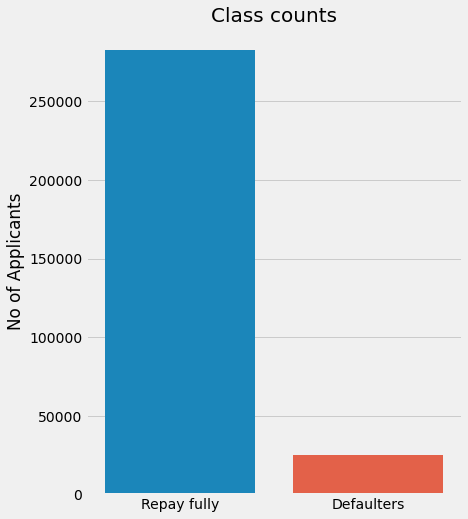

In [8]:
#Credit: https://towardsdatascience.com/predicting-loan-repayment-5df4e0023e92
# Get number of positve and negative examples
pos = df_train[df_train["TARGET"] == 1].shape[0] # default
neg = df_train[df_train["TARGET"] == 0].shape[0] # Repay fully
print("Defaulters examples = {}".format(pos))
print("Repay fully examples = {}".format(neg))
print("Proportion of Defaulters to Repay examples = {:.2f}%".format((pos / neg)*100 ))
plt.figure(figsize=(6, 8))
sns.countplot(x=df_train["TARGET"])
plt.xticks((0, 1), ["Repay fully", "Defaulters"])
plt.xlabel("")
plt.ylabel("No of Applicants")
plt.title("Class counts", y=1, fontdict={"fontsize": 20});

plt.show()

- Observation
    - It clearly shows that imbalanced data. 
    - The Defaulters case (minority class percentage 8.78%) are very less compare to the applicants who pays regularly (majority class)
    - Better metrics would be AUC[Area under the ROC Curve] and F1-Score would be better metrics.
    - F1-score is product of precision and recall.
    - In order to balance the class labels, we can eight try under sample or over sample. The problem with under sample will lose information and dataset will become small which might impact model performance like high bias
    - Alternative is over sample the minority class [Defaulters data]. But this might overfit the Model. However, using Hyper parameters we can set the right parameters.
    - SMOTE[Synthetic Minority OverSampling Technique] is good technique to over sampling. However, Model will operate on feature space not an the data space.
    - Various ways to use SMOTE technique to generate more minority classes
        - K-Nearest neighbours  for all minorty classes
        - Choose random number between 1 and k
        - For each feature,
            - Compute the difference between minority  sample  and its randomly chosen  neighbour
            - Multity the difference with random number 0 and 1
            - Add the synthetic points to dataset. 
         - Repeat the step still the minority classes balances with majority classes.
    - Confusion Matrix - False Negative misclassying points are very costly from business perspective. Example, if the Model classifies that Applicant will repay fully and lenders lend the money to applicant and Applicant actually defaults. It will be big loss to lenders.
    - Confusion Matrix - False Positive misclassifying points are revenue loss only. Example, If the Model classifies that Applicant will defaults and hence lenders rejects the applicants but actually Applicant has the ability to repay the loan fully. This case, Interest loss to lenders. 
    - Comparing FN to FP, FN is more serious. Hence we can reduce cut-off points to reduce the False Negatives cases. 
    - Recall metric will consider False Negative cases. Whereas Precision metric considers False Positive. Hence, Recall is more important.
    - Ensemble Models like XGBoost/LightGBM Random Forest, we can use class weights to balance the Model.
    - While hyper tuning, will use 10 k-fold CV to find best Model which performs  
    - In Deep Networking, will try use 'relu' activation function in Input and hidden layers, 'sigmoid' in output layer since it is binary classification.
    - Dropouts and BatchNormalization to ensure the network doesn't overfit.
    - Adam optimizer converges faster with proper learning rate and Loss function as 'binary_crossentropy'.
    - Deep Network, will be trained with Upsampling [SMOTE] and Undersampling and plot the confusion metrics to identify which model is better and reduces FN.
    
    - Also this is two class classification problem.

## Exploratory Data Analysis [EDA]

<img src='https://i.imgur.com/h7DK1tB.png'>
Credit:https://becominghuman.ai/lightgbm-on-home-credit-default-risk-prediction-5b17e68a6e9

In [9]:
pd.set_option('display.max_columns', None) 

In [10]:
# Check both the datatypes and if there is missing values print(f"Data types:\n{11 * '-'}")
print(f"{df_train.dtypes}\n")

# Check if there any null values?
print(f"Sum of null values in each feature:\n{35 * '-'}")
nullcol=df_train.isnull().sum()
print(nullcol[nullcol>0])


SK_ID_CURR                      int32
TARGET                           int8
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float16
AMT_REQ_CREDIT_BUREAU_WEEK    float16
AMT_REQ_CREDIT_BUREAU_MON     float16
AMT_REQ_CREDIT_BUREAU_QRT     float16
AMT_REQ_CREDIT_BUREAU_YEAR    float16
Length: 122, dtype: object

Sum of null values in each feature:
-----------------------------------
AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
NAME_TYPE_SUITE                 1292
OWN_CAR_AGE                   202929
OCCUPATION_TYPE                96391
                               ...  
AMT_REQ_CREDIT_BUREAU_DAY      41519
AMT_REQ_CREDIT_BUREAU_WEEK     41519
AMT_REQ_CREDIT_BUREAU_MON      41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
AMT_REQ_CREDIT_BUREAU_YEAR     41519
Length: 67, dtype: int64


- Observation:
     - It clearly shows lot of missing values. Strategy to impute the missing values are Median, Mean and Mode. 
     - If the missing data is more in any of the column more than 50%, will remove the column
     - If the missing data at row level is more than 40% will remove the record. 

#### Read Test Data

In [11]:
df_test = reduce_memory_usage(pd.read_csv('./data/application_test.csv', encoding= 'unicode_escape'))
print('Number of data points : ', df_test.shape[0])
print('Number of features : ', df_test.shape[1])

Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Number of data points :  48744
Number of features :  121


#### Categorical, Numerical Features split

In [12]:
categorical_columns=df_train.select_dtypes(include=object).columns.to_list()
numerical_columns=df_train.select_dtypes(exclude=object).columns.to_list()

In [13]:
len(numerical_columns)

106

In [14]:
len(categorical_columns)

16

- Observation:
    - Total of 122 features, in which 16 categorical and 106 numerical. No Text column

### Find Missing Data

In [15]:
# Function to calculate missing values by column# Funct 
def find_missing_values(df, df_name,print_info = False):
    # Total missing values
    mis_val = df.isnull().sum().sort_values(ascending=False)
        
    # Percentage of missing values
    percentage = 100 * mis_val / len(df)
        
    # Make a table with the results
    mis_val_table= pd.concat([mis_val, percentage], axis=1)
        
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].round(1)
        
    if print_info:
        # Print some summary information
        print ("Dataframe "+df_name +" has " + str(df.shape[1]) + " columns.\n"      
                "There are " + str(mis_val_table_ren_columns.shape[0]) +
                  " columns that have missing values.")
        
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [16]:
find_missing_values(df_train,'df_train',True)

Dataframe df_train has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
...                                  ...                ...
EXT_SOURCE_2                         660                0.2
AMT_GOODS_PRICE                      278                0.1
AMT_ANNUITY                           12                0.0
CNT_FAM_MEMBERS                        2                0.0
DAYS_LAST_PHONE_CHANGE                 1                0.0

[67 rows x 2 columns]

In [17]:
find_missing_values(df_test,'df_test',True)

Dataframe df_test has 121 columns.
There are 64 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_AVG                     33495               68.7
COMMONAREA_MODE                    33495               68.7
COMMONAREA_MEDI                    33495               68.7
NONLIVINGAPARTMENTS_AVG            33347               68.4
NONLIVINGAPARTMENTS_MODE           33347               68.4
...                                  ...                ...
OBS_30_CNT_SOCIAL_CIRCLE              29                0.1
OBS_60_CNT_SOCIAL_CIRCLE              29                0.1
DEF_60_CNT_SOCIAL_CIRCLE              29                0.1
AMT_ANNUITY                           24                0.0
EXT_SOURCE_2                           8                0.0

[64 rows x 2 columns]

#### Plot Missing data 

Text(0.5, 0, 'Columns')

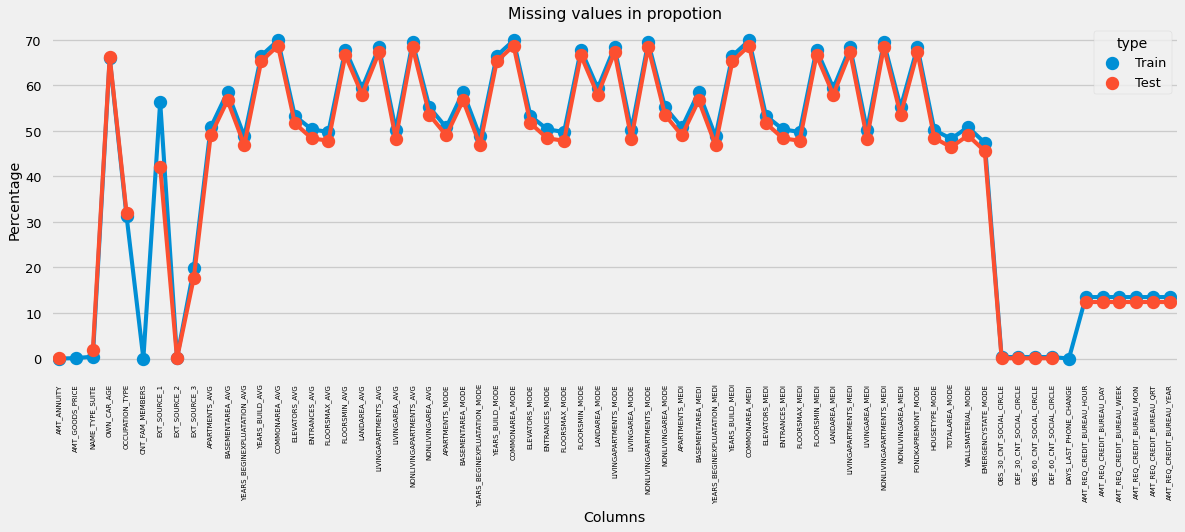

In [18]:
plt.style.use('seaborn-talk')
fig = plt.figure(figsize=(18,6))

#find all missing values in train data
nullcol=df_train.isnull().sum()
missing_values = nullcol[df_train.isnull().sum()>0]

miss_train = pd.DataFrame((missing_values)*100/df_train.shape[0]).reset_index()
missing_values_test = df_test.isnull().sum()
miss_test = pd.DataFrame((missing_values_test[missing_values_test>0])*100/df_test.shape[0]).reset_index()
miss_train["type"] = "Train"
miss_test["type"]  =  "Test"
missing = pd.concat([miss_train,miss_test],axis=0)
ax = sns.pointplot(x="index",y=0,data=missing,hue="type")

plt.xticks(rotation =90,fontsize =7)
plt.title("Missing values in propotion")
plt.ylabel("Percentage")
plt.xlabel("Columns")

In [19]:
#credit:https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2
def remove_missing_columns(df, threshold = 80):
    #dataframe
    count = df.isnull().sum().sort_values(ascending=False)
    percentage = ((df.isnull().sum()/len(df)*100)).sort_values(ascending=False)
    train_miss = pd.concat([count, percentage], axis=1, keys=['Count','Percentage'])

    # list of missing columns
    missing_columns=list(train_miss.loc[(train_miss['Percentage']>threshold)].index)
    
    # Combine the two lists together
    missing_columns = np.array(missing_columns)
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    df.drop(columns = missing_columns,axis=1,inplace=True)
    
    return df

In [20]:
#filter columns having more than 80% of missing data which is no use
#print # of columns in df_train before removing
print('# of columns before removing in train ~> {}'.format(df_train.shape[1]))
#drop columns
df_train =remove_missing_columns(df_train,threshold=80)
print('# of columns after removing in train ~> {}'.format(df_train.shape[1]))


#print # of columns in df_test before removing
print('# of columns before removing in test ~> {}'.format(df_test.shape[1]))
#drop columns
df_test=remove_missing_columns(df_test,threshold=80)
#print # of columns in df_train after removing
print('# of columns after removing in test ~> {}'.format(df_test.shape[1]))

# of columns before removing in train ~> 122
There are 0 columns with greater than 80% missing values.
# of columns after removing in train ~> 122
# of columns before removing in test ~> 121
There are 0 columns with greater than 80% missing values.
# of columns after removing in test ~> 121


Text(0.5, 0, 'Columns')

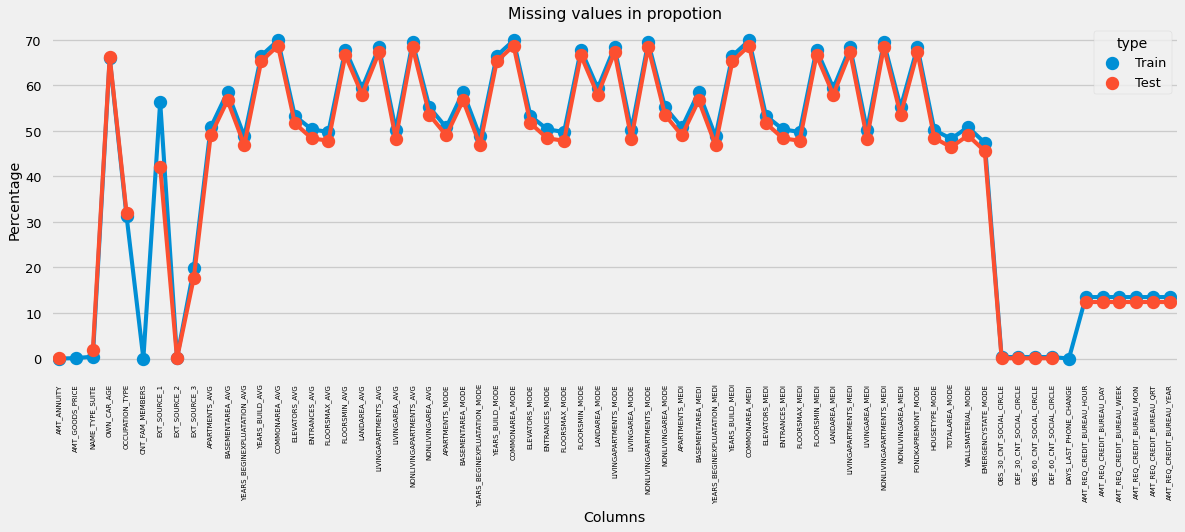

In [21]:
#after removing columns plot again
fig = plt.figure(figsize=(18,6))

#find all missing values in train data
nullcol=df_train.isnull().sum()
missing_values = nullcol[df_train.isnull().sum()>0]

miss_train = pd.DataFrame((missing_values)*100/df_train.shape[0]).reset_index()
missing_values_test = df_test.isnull().sum()
miss_test = pd.DataFrame((missing_values_test[missing_values_test>0])*100/df_test.shape[0]).reset_index()
miss_train["type"] = "Train"
miss_test["type"]  =  "Test"
missing = pd.concat([miss_train,miss_test],axis=0)
ax = sns.pointplot(x="index",y=0,data=missing,hue="type")

plt.xticks(rotation =90,fontsize =7)
plt.title("Missing values in propotion")
plt.ylabel("Percentage")
plt.xlabel("Columns")

#### Impute Mode for categorical values and Median with Numerical values

In [22]:
#before imputing, replace infinite values with np.nan values. Inputer will update with median values
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [23]:
numerical_columns=df_train.select_dtypes(exclude=object).columns.to_list()
numerical_columns.remove('TARGET')
print(np.all(np.isfinite(df_train[numerical_columns])))
print(np.all(np.isfinite(df_test[numerical_columns])))

False
False


In [24]:
df_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

#### Find Negative values 

In [25]:
#Before imputing with Mean / Median, fix the negative values. otherwise, median/ mean will be wrong
#find numeric columns having negative values.
negative_value_columns=[]
for cols in numerical_columns:
    if (np.any(df_train[cols]<0)):
        negative_value_columns.append(cols)

for col in negative_value_columns:
    print('column {} having min value ~> {} and max values {}'.format(col, df_train[col].min(),df_train[col].max()))

column DAYS_BIRTH having min value ~> -25229 and max values -7489
column DAYS_EMPLOYED having min value ~> -17912 and max values 365243
column DAYS_REGISTRATION having min value ~> -24672.0 and max values 0.0
column DAYS_ID_PUBLISH having min value ~> -7197 and max values 0
column DAYS_LAST_PHONE_CHANGE having min value ~> -4292.0 and max values 0.0


- Observation:
 - Columns DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH and DAYS_LAST_PHONE_CHANGE have negative values
 - Column DAYS_EMPLOYED having max value of 365243 which is clearly shows as Error. Hence, fix DAYS_EMPLOYED > 0 to 0
 - Finally convert all negative values to positive and convert them into years with max of 1 digit.

In [26]:
#fix DAYS_EMPLOYED error:
df_train.loc[df_train['DAYS_EMPLOYED']>0,'DAYS_EMPLOYED']=0
df_test.loc[df_test['DAYS_EMPLOYED']>0,'DAYS_EMPLOYED']=0

In [27]:
#before function convert negative values to postive and convert them into years. 
def convert_negative_days_year(days_negative):
    #convert negative values to positive, and divide by 365 days to convert years
    #finally rounded to 1 decimal.
    return np.round(abs(days_negative)/365,1)

#Train
df_train['Age'] = convert_negative_days_year(df_train['DAYS_BIRTH'])
df_train['Employment'] = convert_negative_days_year(df_train['DAYS_EMPLOYED'])
df_train['Phone_change_Years'] = convert_negative_days_year(df_train['DAYS_LAST_PHONE_CHANGE'])
df_train['Registration_Years'] = convert_negative_days_year(df_train['DAYS_REGISTRATION'])
df_train['Id_Publish_Years'] = convert_negative_days_year(df_train['DAYS_ID_PUBLISH'])
 

#test
df_test['Age'] = convert_negative_days_year(df_test['DAYS_BIRTH'])
df_test['Employment'] = convert_negative_days_year(df_test['DAYS_EMPLOYED'])
df_test['Phone_change_Years'] = convert_negative_days_year(df_test['DAYS_LAST_PHONE_CHANGE'])
df_test['Registration_Years'] = convert_negative_days_year(df_test['DAYS_REGISTRATION'])
df_test['Id_Publish_Years'] = convert_negative_days_year(df_test['DAYS_ID_PUBLISH'])

- Observation:
    - All negative numeric columns are converted into positive and years
    - Dropped original columns and added with new columns

#### Fill missing values with Median values for numeric columns and most frequent with categorical columns 

In [28]:
def fill_median_value(df):
    num_cols=df.select_dtypes(exclude=object).columns
    for col in num_cols:
        df[col].fillna(df[col].median(axis=0,skipna = True),inplace=True)
    return pd.DataFrame(df)

In [29]:
def fill_mostfrequent_value(df):
    cat_cols=df.select_dtypes(include=object).columns #categorical values
    for col in cat_cols:
        df[col].fillna(df[col].value_counts().index[0], inplace=True)
    return pd.DataFrame(df)

In [30]:
#fill median value for Numerical columns
df_train = fill_median_value(df_train)
df_test =  fill_median_value(df_test)

#fill most frequent value for categorical columns
df_train = fill_mostfrequent_value(df_train)
df_test =  fill_mostfrequent_value(df_test)

In [31]:
df_train = reduce_memory_usage(df_train)
df_test = reduce_memory_usage(df_test)
print('Number of Train data points after imputation : ', df_train.shape[0])
print('Number of Train features  after imputation : ', df_train.shape[1])
print("="*50)
print('Number of Test data points after imputation : ', df_test.shape[0])
print('Number of Test features  after imputation : ', df_test.shape[1])

Memory usage of dataframe is 101.76 MB
Memory usage after optimization is: 94.72 MB
Decreased by 6.9%
Memory usage of dataframe is 16.08 MB
Memory usage after optimization is: 14.97 MB
Decreased by 6.9%
Number of Train data points after imputation :  307511
Number of Train features  after imputation :  127
Number of Test data points after imputation :  48744
Number of Test features  after imputation :  126


In [32]:
numerical_columns=df_train.select_dtypes(exclude=object).columns.to_list()
cat_columns=df_train.select_dtypes(include=object).columns.to_list()

numerical_columns.remove('TARGET')
print(np.any(np.isfinite(df_train[numerical_columns])))
print(np.any(np.isfinite(df_test[numerical_columns])))


True
True


In [45]:
x = PrettyTable()
x.field_names = ["Sl.No","column", "IQR value","Q1-1.5IQR","Q3+1.5IQR"]

# IQR
for idx,nc in enumerate(numerical_columns):
    col=df_train[nc].values
    col = col[~np.isnan(col)]
    Q1 = np.percentile(col, 25,interpolation = 'midpoint')
    Q3 = np.percentile(col, 75,interpolation = 'midpoint')
    Q1_15IQR = Q1-np.round((Q3-Q1),2)
    Q3_15IQR = Q3+np.round((Q3-Q1),2)
    x.add_row([idx+1,nc,np.round((Q3-Q1),2),Q1_15IQR,Q3_15IQR])
    
x.sortby = "Q1-1.5IQR"
x.reversesort = True
x.sortby = "Q3+1.5IQR"
x.reversesort = True
x.align["Q1_15IQR"] = "r"
x.align["Q3_15IQR"] = "r"
print(x)

+-------+------------------------------+-----------+-----------------------+-----------------------+
| Sl.No |            column            | IQR value |       Q1-1.5IQR       |       Q3+1.5IQR       |
+-------+------------------------------+-----------+-----------------------+-----------------------+
|   4   |          AMT_CREDIT          |  538650.0 |       -268650.0       |       1347300.0       |
|   6   |       AMT_GOODS_PRICE        |  441000.0 |       -202500.0       |       1120500.0       |
|   1   |          SK_ID_CURR          |  177997.0 |        11148.5        |        545139.5       |
|   3   |       AMT_INCOME_TOTAL       |  90000.0  |        22500.0        |        292500.0       |
|   5   |         AMT_ANNUITY          |  18072.0  |        -1548.0        |        52668.0        |
|   10  |      DAYS_REGISTRATION       |   5470.0  |        -12950.0       |         3460.0        |
|   9   |        DAYS_EMPLOYED         |   2471.0  |        -5231.0        |         2182.0

In [46]:
#checking why still infinite vlaues are repeating. 
df1 = df_train.copy(deep=True)
df2 = df_test.copy(deep=True)
df1.replace([np.inf, -np.inf], np.nan, inplace=True)
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df1.dropna(inplace=True)
df2.dropna(inplace=True)
print(df1.shape)
print(df2.shape)

(307511, 127)
(48744, 126)


- Observation:
    - All missing columns are imputed with median and most frequent values. 
    - Train and Test have same number of columns

In [47]:
#since the dataset is very large, manually invoke gc to remove from the memory
gc.enable()
del df1,df2
gc.collect()

599

In [48]:
#after fixing median and most frequent values for numeric and catacorical featuers,  plot again
#find all missing values in train data
if df_train.isnull().sum().sum() >0:
    fig = plt.figure(figsize=(18,6))
    nullcol=df_train.isnull().sum()
    missing_values = nullcol[df_train.isnull().sum()>0]

    miss_train = pd.DataFrame((missing_values)*100/df_train.shape[0]).reset_index()
    missing_values_test = df_test.isnull().sum()
    miss_test = pd.DataFrame((missing_values_test[missing_values_test>0])*100/df_test.shape[0]).reset_index()
    miss_train["type"] = "Train"
    miss_test["type"]  =  "Test"
    missing = pd.concat([miss_train,miss_test],axis=0)
    ax = sns.pointplot(x="index",y=0,data=missing,hue="type")

    plt.xticks(rotation =90,fontsize =7)
    plt.title("Missing values in propotion")
    plt.ylabel("Percentage")
    plt.xlabel("Columns")
else:
    print("df_train dataset doesn't have missing values..")

df_train dataset doesn't have missing values..


In [49]:
def plot_heatmap_for_corr(df):
    corr=df.corr()
    plt.figure(figsize=(12, 10))

    sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [50]:
def remove_corr_features(cols):
    #below columns are highly correlated with other columns, hence, remove from df_train and df_test and replot heatmap again
    #print # of columns in df_train before removing
    print('# of columns before removing in train ~> {}'.format(len(df_train.columns)))
    
    #drop columns
    df_train.drop(cols,axis=1,inplace=True)
    #final columns after removing
    print('# of columns after removing in train ~> {}'.format(len(df_train.columns)))

    #print # of columns in df_test before removing
    print('# of columns before removing in test ~> {}'.format(len(df_test.columns)))
    #drop columns
    df_test.drop(cols,axis=1,inplace=True)
    #final columns after removing
    print('# of columns after removing in test~> {}'.format(len(df_test.columns)))
    
    return

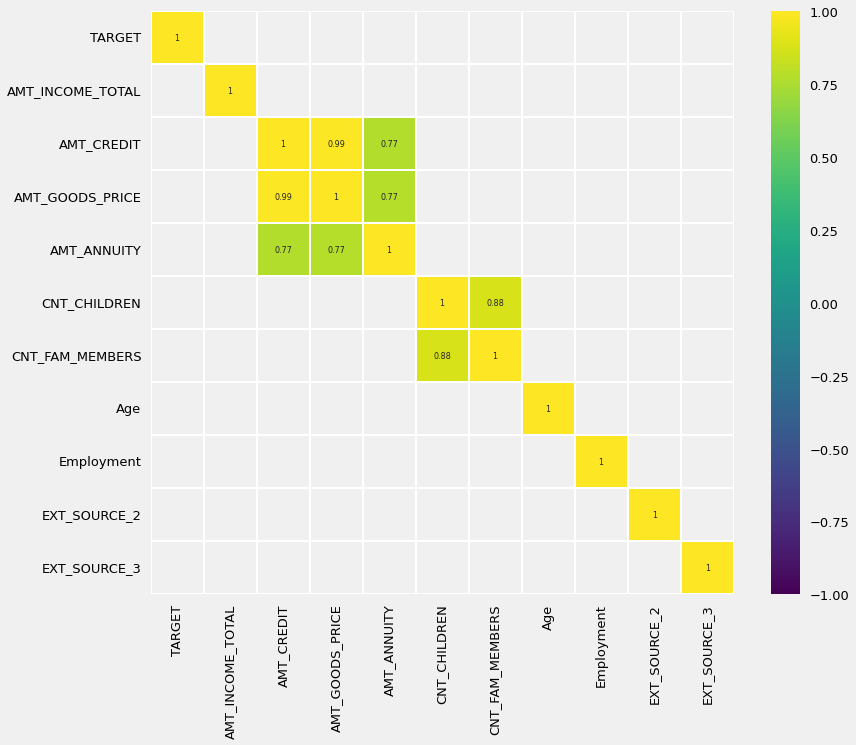

In [51]:
#Try few features to find the correlation
reduced_features_columns = [
    'TARGET','NAME_CONTRACT_TYPE','NAME_FAMILY_STATUS','CODE_GENDER',
    'FLAG_OWN_CAR','FLAG_OWN_REALTY','AMT_INCOME_TOTAL','AMT_CREDIT',
    'AMT_GOODS_PRICE','NAME_INCOME_TYPE','AMT_ANNUITY','NAME_EDUCATION_TYPE',
    'CNT_CHILDREN','CNT_FAM_MEMBERS','Age','Employment','EXT_SOURCE_2','EXT_SOURCE_3'
]
df_reduced_features=df_train[reduced_features_columns]
plot_heatmap_for_corr(df_reduced_features)

In [40]:
#Though 'AMT_GOODS_PRICE','AMT_ANNUITY' have highly correlated, we can still do some FE based on these fields. hence not removing. 
#only count of family members field removed as it is highly correlated with cnt_children. 
cols=['CNT_FAM_MEMBERS']
remove_corr_features(cols)

# of columns before removing in train ~> 127
# of columns after removing in train ~> 126
# of columns before removing in test ~> 126
# of columns after removing in test~> 125


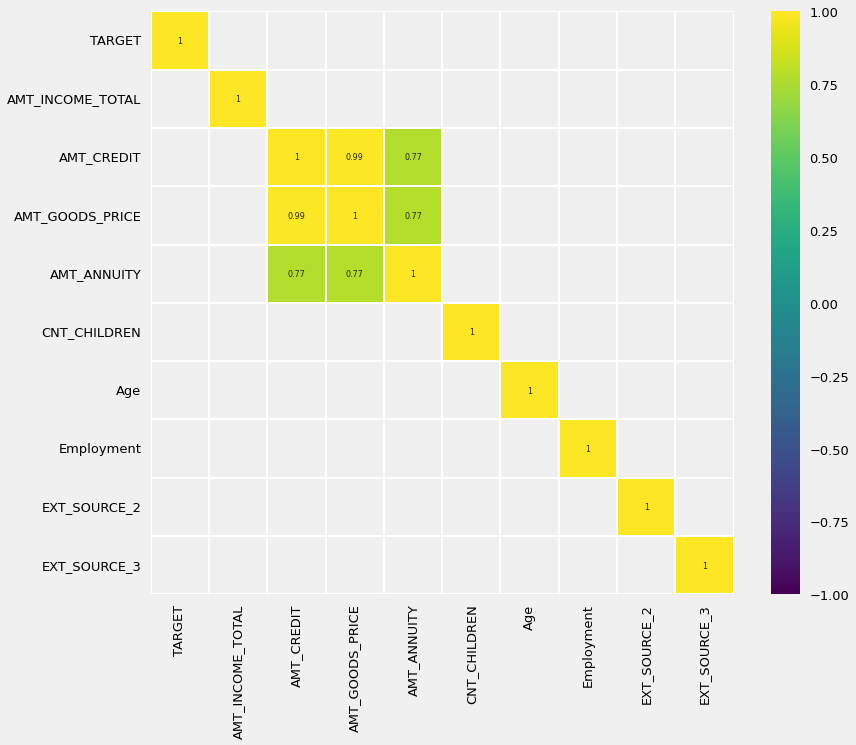

In [41]:
for col in cols:
    reduced_features_columns.remove(col)
df_reduced_features=df_train[reduced_features_columns]
plot_heatmap_for_corr(df_reduced_features)

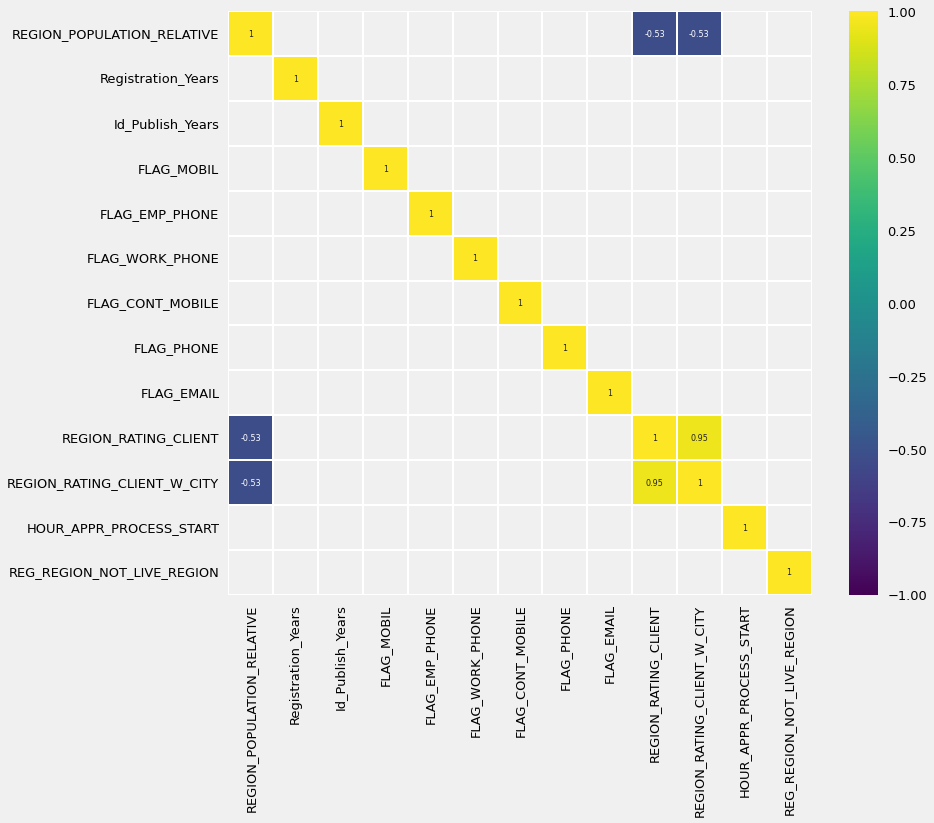

In [42]:
#Next set of columns to check correlation
reduced_features_columns =[
 'NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS', 
 'NAME_HOUSING_TYPE','REGION_POPULATION_RELATIVE','Registration_Years','Id_Publish_Years','FLAG_MOBIL', 
 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL','OCCUPATION_TYPE', 
 'REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 
 'REG_REGION_NOT_LIVE_REGION'
 ]
df_reduced_features=df_train[reduced_features_columns]
plot_heatmap_for_corr(df_reduced_features)

In [43]:
cols=['REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY']
remove_corr_features(cols)

# of columns before removing in train ~> 126
# of columns after removing in train ~> 124
# of columns before removing in test ~> 125
# of columns after removing in test~> 123


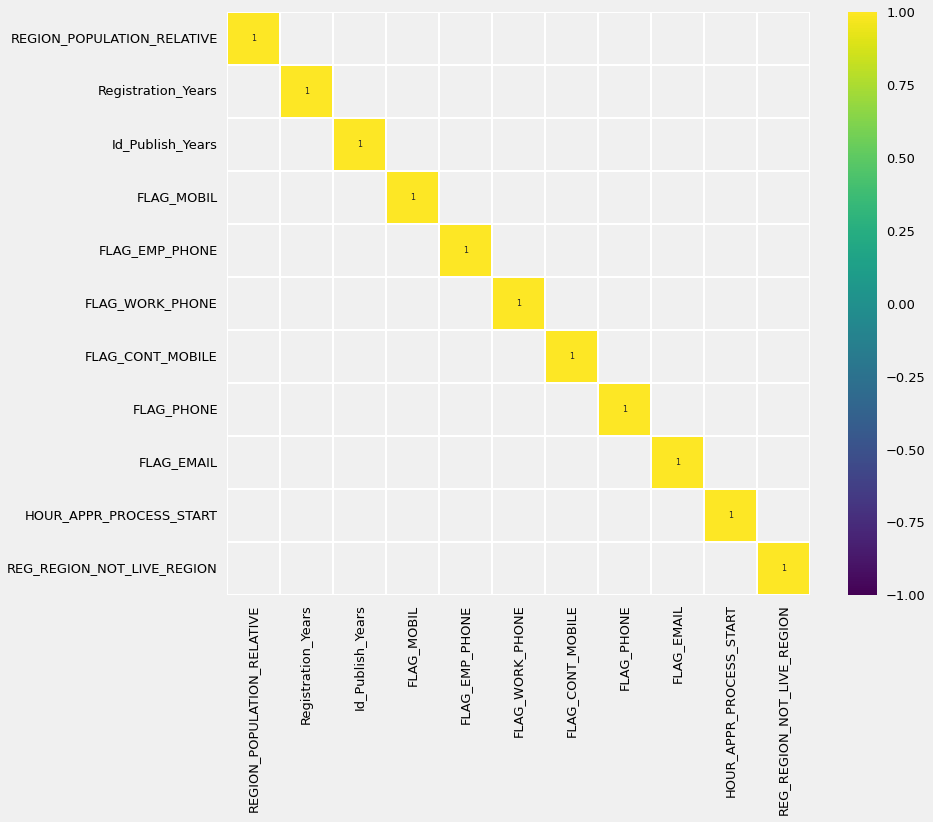

In [44]:
for col in cols:
    reduced_features_columns.remove(col)
df_reduced_features=df_train[reduced_features_columns]
plot_heatmap_for_corr(df_reduced_features)

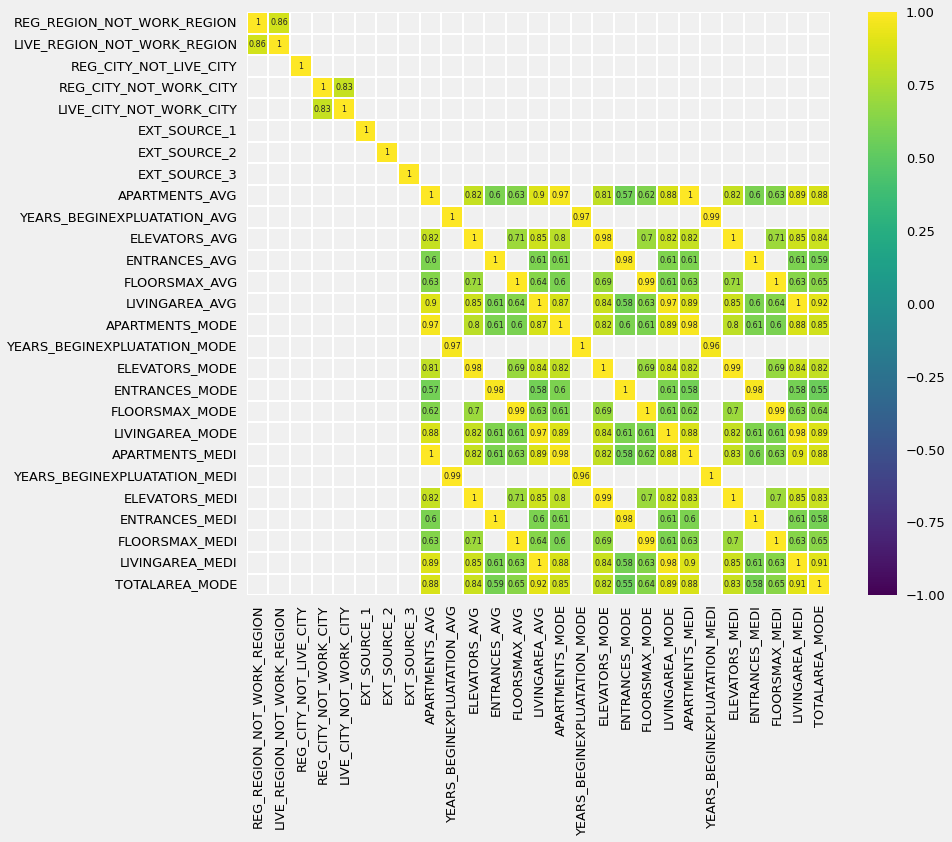

In [45]:
reduced_features_columns=['REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY','ORGANIZATION_TYPE','EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG',
'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG','FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'APARTMENTS_MODE',
'YEARS_BEGINEXPLUATATION_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE','FLOORSMAX_MODE', 'LIVINGAREA_MODE', 'APARTMENTS_MEDI',
'YEARS_BEGINEXPLUATATION_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI','FLOORSMAX_MEDI', 'LIVINGAREA_MEDI', 'HOUSETYPE_MODE', 'TOTALAREA_MODE']

df_reduced_features=df_train[reduced_features_columns]
plot_heatmap_for_corr(df_reduced_features)


In [46]:
#AVG and Mode are repeated columns, let us remove it. 
# will add mean, median  statical features later for all numerical fields.
cols=['LIVE_REGION_NOT_WORK_REGION', 'LIVE_CITY_NOT_WORK_CITY','ELEVATORS_AVG', 'ENTRANCES_AVG','LIVINGAREA_AVG', 
      'APARTMENTS_MODE','YEARS_BEGINEXPLUATATION_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE','FLOORSMAX_MODE',
      'LIVINGAREA_MODE', 'APARTMENTS_MEDI','ELEVATORS_MEDI','ENTRANCES_MEDI','FLOORSMAX_MEDI', 'LIVINGAREA_MEDI', 
      'HOUSETYPE_MODE', 'TOTALAREA_MODE','YEARS_BEGINEXPLUATATION_MEDI','FLOORSMAX_AVG']
remove_corr_features(cols)

# of columns before removing in train ~> 124
# of columns after removing in train ~> 104
# of columns before removing in test ~> 123
# of columns after removing in test~> 103


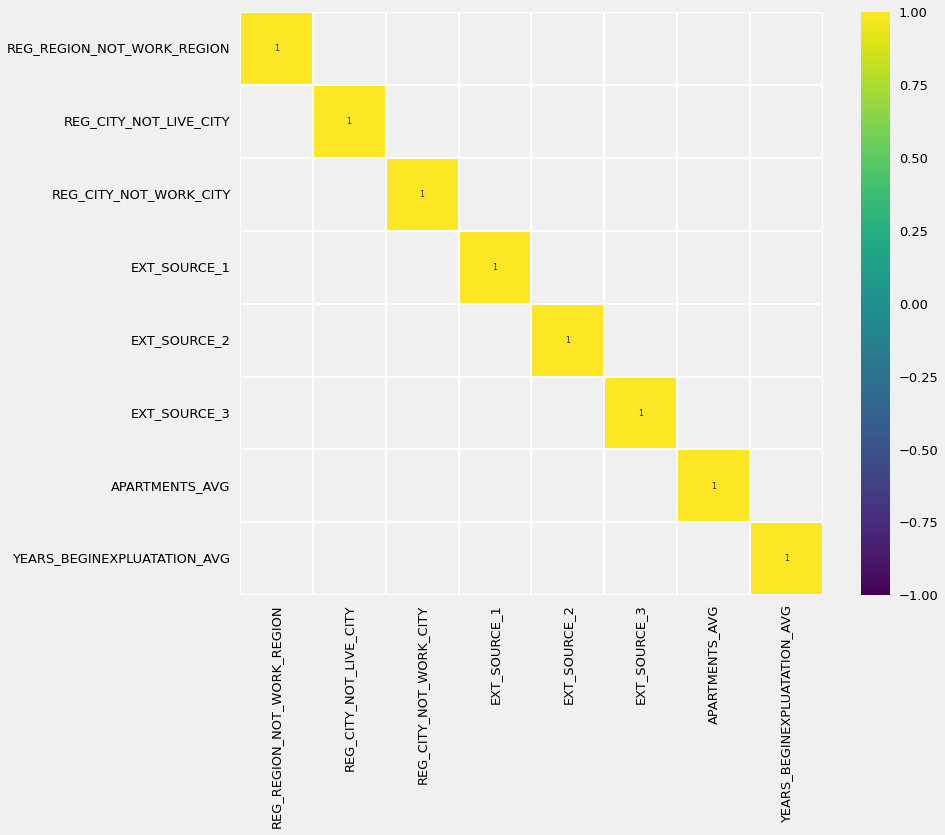

In [47]:
for col in cols:
    reduced_features_columns.remove(col)
df_reduced_features=df_train[reduced_features_columns]
plot_heatmap_for_corr(df_reduced_features)

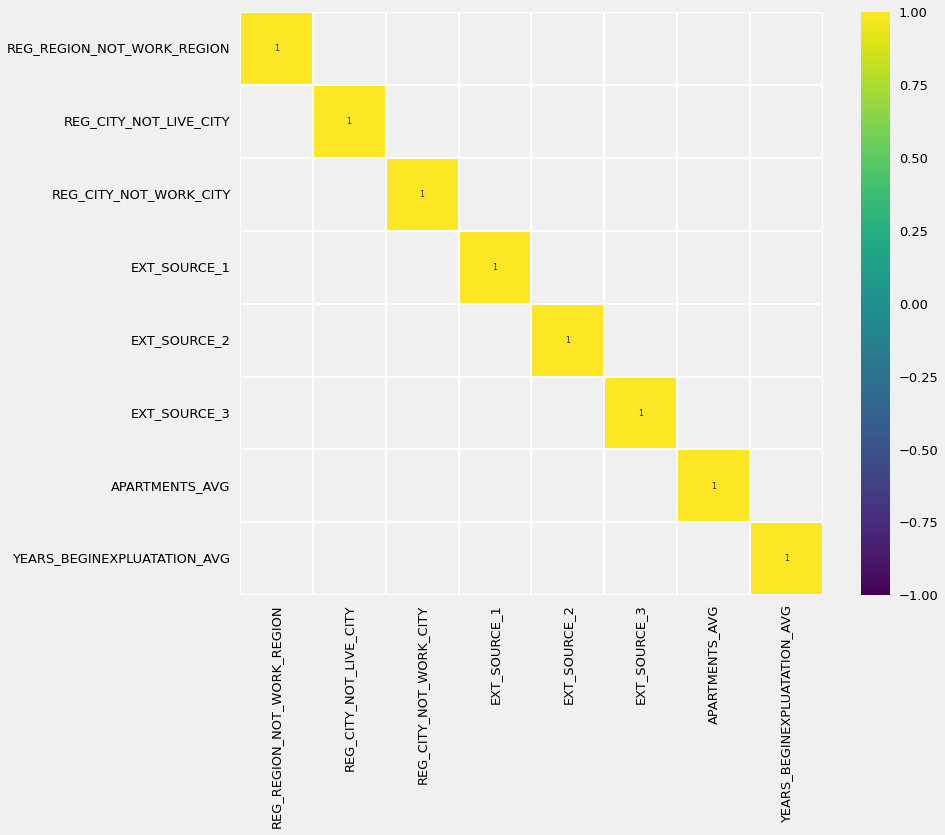

In [48]:
df_reduced_columns=['WALLSMATERIAL_MODE',
       'EMERGENCYSTATE_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
       'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR']

df_reduced_features=df_train[reduced_features_columns]
plot_heatmap_for_corr(df_reduced_features)

In [49]:
cols=['FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE']
for col in cols:
    df_reduced_columns.remove(col)

remove_corr_features(cols)

# of columns before removing in train ~> 104
# of columns after removing in train ~> 100
# of columns before removing in test ~> 103
# of columns after removing in test~> 99


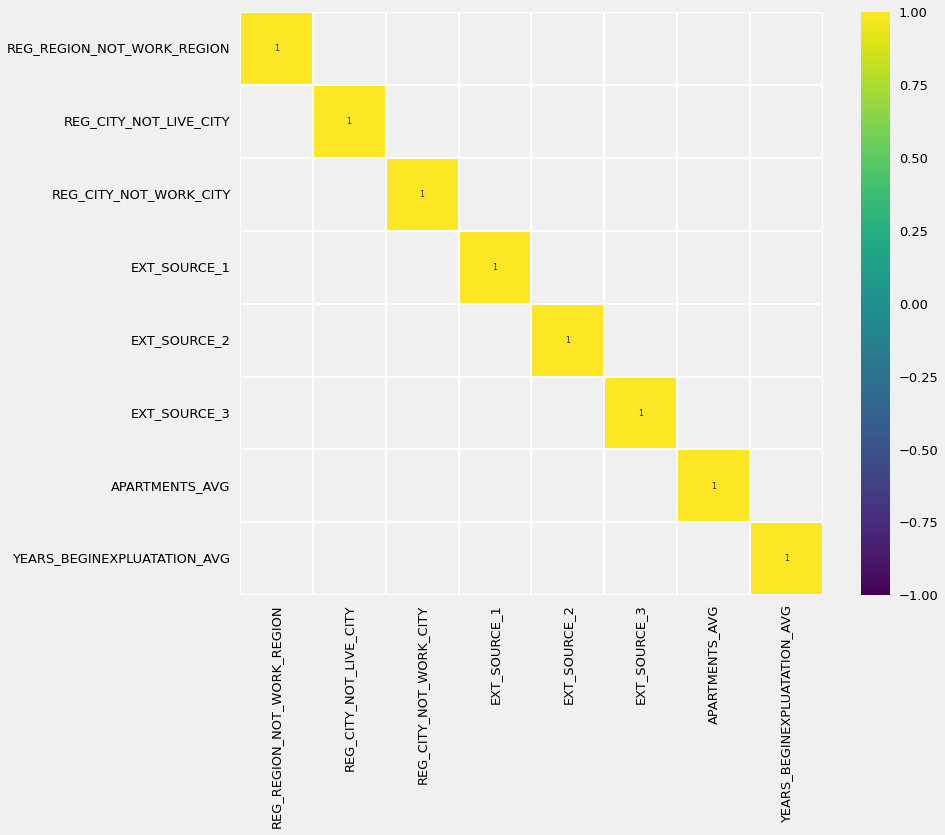

In [50]:
df_reduced_features=df_train[reduced_features_columns]
plot_heatmap_for_corr(df_reduced_features)

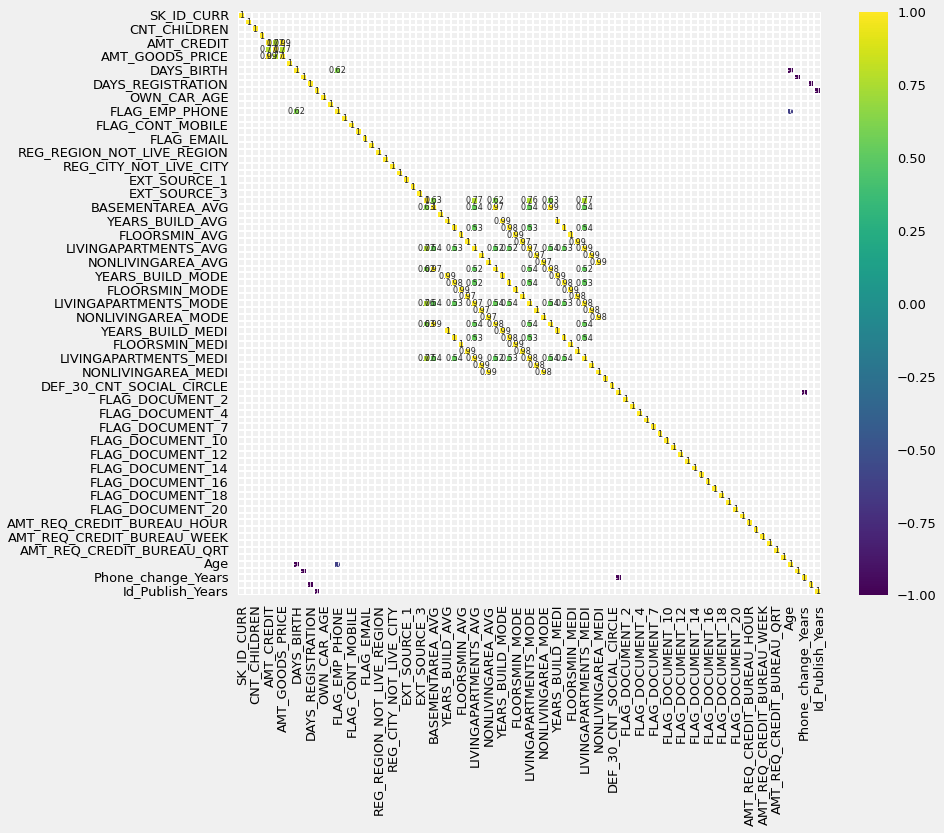

In [51]:
#plot with all features check any features are highly correlated. 
plot_heatmap_for_corr(df_train)

# of columns before removing in train ~> 100
# of columns after removing in train ~> 84
# of columns before removing in test ~> 99
# of columns after removing in test~> 83


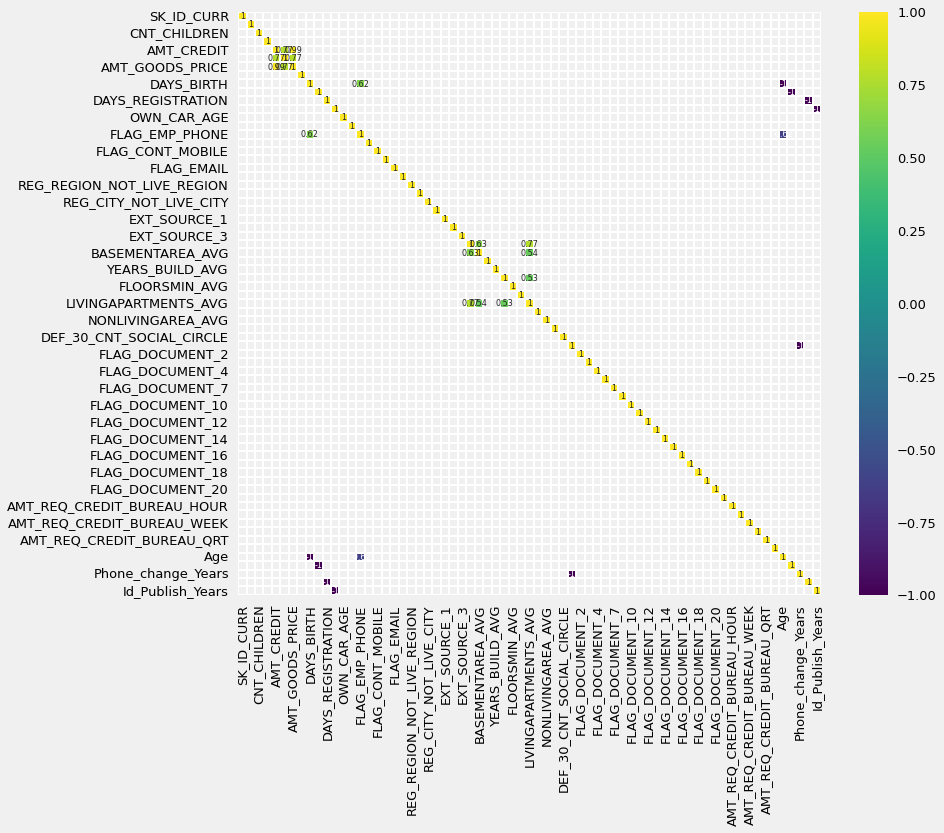

In [52]:
cols=['BASEMENTAREA_MODE','BASEMENTAREA_MEDI','YEARS_BUILD_MODE','YEARS_BUILD_MEDI','FLOORSMIN_MODE','FLOORSMIN_MEDI',
      'LIVINGAPARTMENTS_MODE','LIVINGAPARTMENTS_MEDI','NONLIVINGAPARTMENTS_MODE','NONLIVINGAPARTMENTS_MEDI',
      'COMMONAREA_MEDI','COMMONAREA_MODE','LANDAREA_MODE','LANDAREA_MEDI','NONLIVINGAREA_MODE','NONLIVINGAREA_MEDI']

remove_corr_features(cols)
#finally plot with all features
plot_heatmap_for_corr(df_train)

In [52]:
print(df_train.columns)

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'Age', 'Employment', 'Phone_change_Years',
       'Registration_Years', 'Id_Publish_Years'],
      dtype='object', length=127)


### Check Duplicate Data Train

In [53]:
columns_without_id = [col for col in df_train.columns if col!='SK_ID_CURR']
#print any duplicate entries in train
print('Number of duplicates in the train data:',df_train[df_train.duplicated(subset = columns_without_id, keep=False)]
      .shape[0])

Number of duplicates in the train data: 0


### Check Duplicate Data in Test

In [54]:
columns_without_id = [col for col in df_test.columns if col!='SK_ID_CURR']
#check any duplicate entries in train
print('Number of duplicates in the test data:',df_test[df_test.duplicated(subset = columns_without_id, keep=False)]
      .shape[0])

Number of duplicates in the test data: 0


### Univariate Analysis

In [55]:
#this method is common to plot histogram with density plot for any feature 
#Univariate Analysis with Histogram with density
def plot_histogram_for_univariate_analysis(data,title,xlabel,ylabel):
    plt.close()

    plt.figure(figsize=(12,5))
    ax = sns.histplot(data=data, kde = True, color='g',bins=50)
    plt.xticks(rotation =90,fontsize =7)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
   
    plt.show()
        
    return

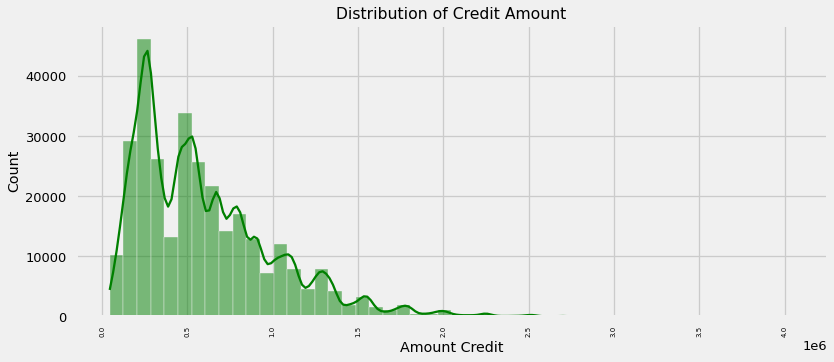

In [56]:
#Credict amount distribution analysis
plot_histogram_for_univariate_analysis(data=df_train["AMT_CREDIT"].dropna(),title="Distribution of Credit Amount",
                                      xlabel="Amount Credit", ylabel="Count")

In [57]:
#Check how many application Total income more than 7million
data=df_train[df_train['AMT_INCOME_TOTAL'] > 700000]['AMT_INCOME_TOTAL']
print('# of applications total income more than 70k is {}'.format(len(data)),end='')
print (' and percentage of the application is {:.2f}%'.format((len(data)/len(df_train))*100))

# of applications total income more than 70k is 738 and percentage of the application is 0.24%


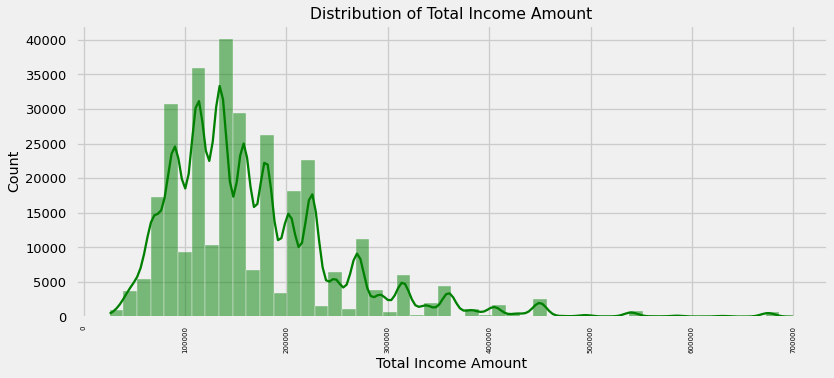

In [58]:
#Filter applications total income is less than 7million and do univariate anaysis on that
data=df_train[df_train['AMT_INCOME_TOTAL'] < 700000]['AMT_INCOME_TOTAL']
plot_histogram_for_univariate_analysis(data=data.dropna(),title="Distribution of Total Income Amount",
                                      xlabel="Total Income Amount", ylabel="Count")

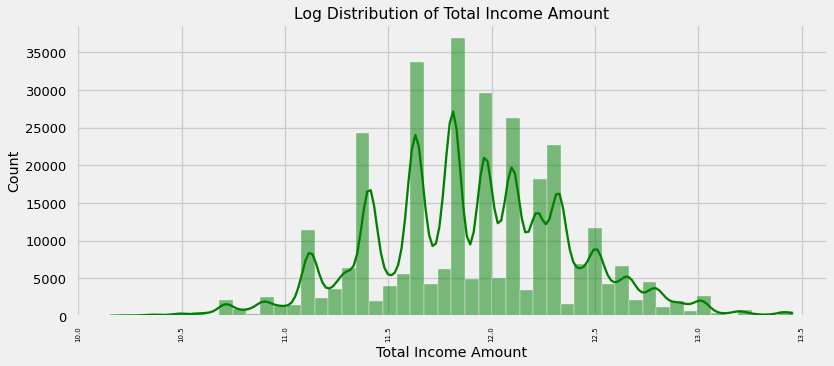

In [59]:
#plot log distribution of Total Income
plot_histogram_for_univariate_analysis(data=np.log(data.dropna()),title="Log Distribution of Total Income Amount",
                                      xlabel="Total Income Amount", ylabel="Count")

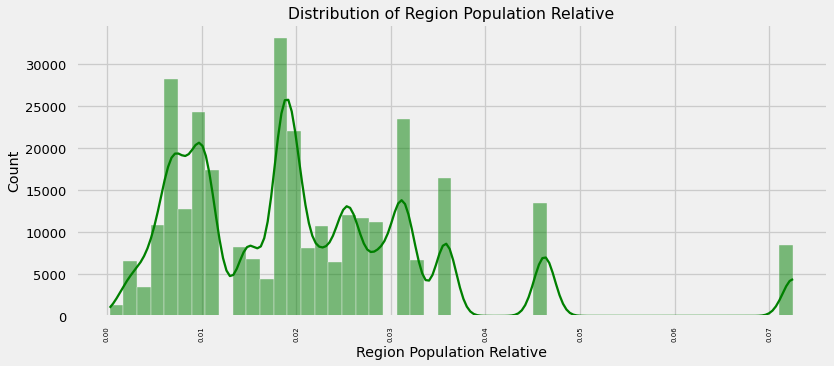

In [60]:
#Region Population Relative distribution analysis
plot_histogram_for_univariate_analysis(data=df_train["REGION_POPULATION_RELATIVE"].dropna(),title="Distribution of Region Population Relative",
                                      xlabel="Region Population Relative", ylabel="Count")

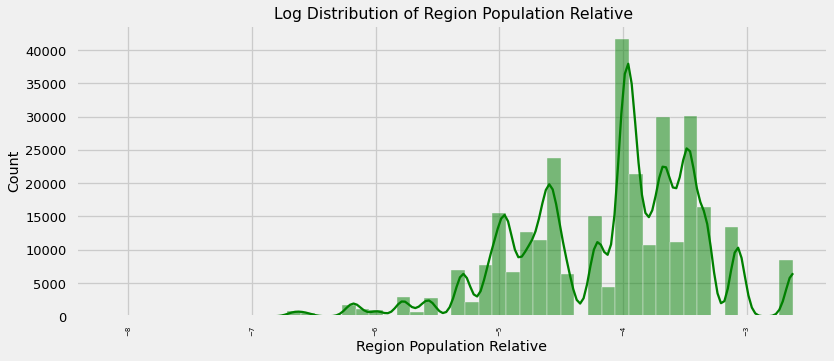

In [61]:
#Region Population Relative distribution analysis
plot_histogram_for_univariate_analysis(data=np.log(df_train["REGION_POPULATION_RELATIVE"].dropna()),title=" Log Distribution of Region Population Relative",
                                      xlabel="Region Population Relative", ylabel="Count")

In [62]:
def plot_kde_distribution(column,title):
    plt.close()
    plt.figure(figsize=(12,5))
    plt.title(title)
    plt.xlabel(column)
    sns.kdeplot(df_train[df_train['TARGET']==0][column], label="Capable of Repaying", color='green')
    sns.kdeplot(df_train[df_train['TARGET']==1][column], label="Defaulters", color='red')
    plt.legend()
    plt.grid()
    plt.show()
 
    return

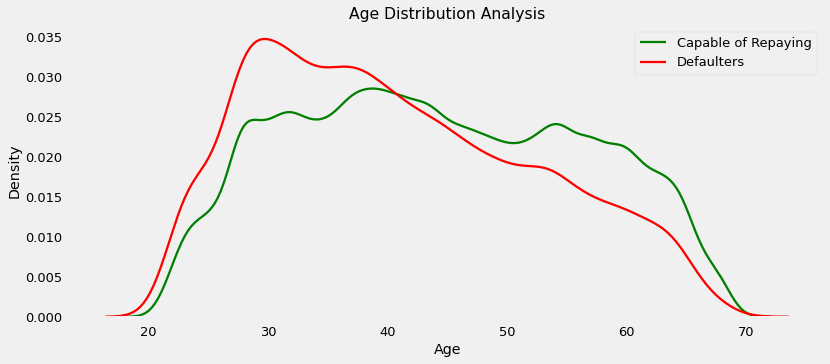

In [63]:
plot_kde_distribution('Age', 'Age Distribution Analysis')

- Observation:
    - Age 25-35  defaulters are high compare the Age above 50.

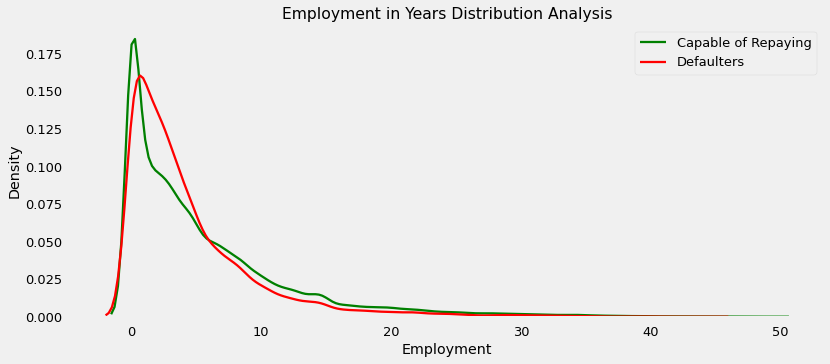

In [64]:
plot_kde_distribution('Employment', 'Employment in Years Distribution Analysis')

- Observation:
    - It clearly shows some error, as Employment in Years can't be more than 100. We should fix it max by 60 years of working and starting age as 20~25. 

- Observation:
    - It clearly shows customers who have 0-10 years employment applies Loan. Approval and rejections are closer in that Employment years.

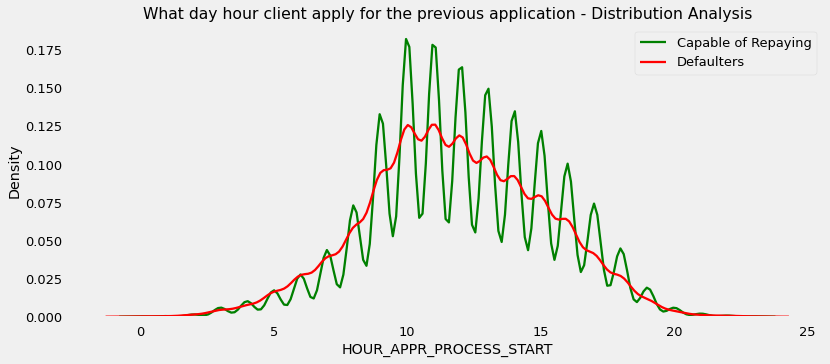

In [65]:
plot_kde_distribution('HOUR_APPR_PROCESS_START', 'What day hour client apply for the previous application - Distribution Analysis')

In [66]:
#stacked bar plots matplotlib: 
#Credit: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def plot_stackedbarchart(data, xtick, col2='TARGET', col3='Total'):
    plt.close()
    ind = np.arange(data.shape[0])
    
    if len(data[xtick].unique())<5:
        plt.figure(figsize=(5,5))
    elif len(data[xtick].unique())>5 & len(data[xtick].unique())<10:
        plt.figure(figsize=(7,7))
    else:
        plt.figure(figsize=(15,15))
  
    p1 = plt.bar(ind, data[col3].values, color='green')
    p2 = plt.bar(ind, data[col2].values, color='red')
    
    plt.ylabel('# of Applications')
    plt.title('# of Applicants who can Repay fully  or Default based on '+xtick ,fontdict={"fontsize": 16})
    plt.xticks(ticks=ind,rotation=90,labels= list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('Repayable', 'Defaults'))
    plt.show()

In [67]:
#Count number of zeros and ones in dataframe python: 
#credit: https://stackoverflow.com/a/51540521/4084039
#Dataframe grouby count: Credit: #https://stackoverflow.com/a/19385591/4084039

def plot_barchart_2columns(data, col1, col2='TARGET', top=False):
    df = pd.DataFrame(df_train.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()
    
    #Total and Average based on the feature
    df['Total'] = pd.DataFrame(data.groupby(col1)[col2].agg(Total='count')).reset_index()['Total']
    df['Average'] = pd.DataFrame(data.groupby(col1)[col2].agg(Average='mean')).reset_index()['Average']
    
    #sort datafarme by total
    df.sort_values(by=['Total'],inplace=True, ascending=False)
    #Incase of more skewed data, filter with max rows
    if top:
        df = temp[0:top]
    #plot_stackedbarchart
    plot_stackedbarchart(df, xtick=col1, col2=col2, col3='Total')
    print('Top 2 records ')               
    print(df.head(2))
    print("="*50)
    print('Bottom 2 records ')    
    print(df.tail(2))
    return

cash loans = 278232
revolving loans = 29279
Proportion of revolving loans to cash loans = 10.52%


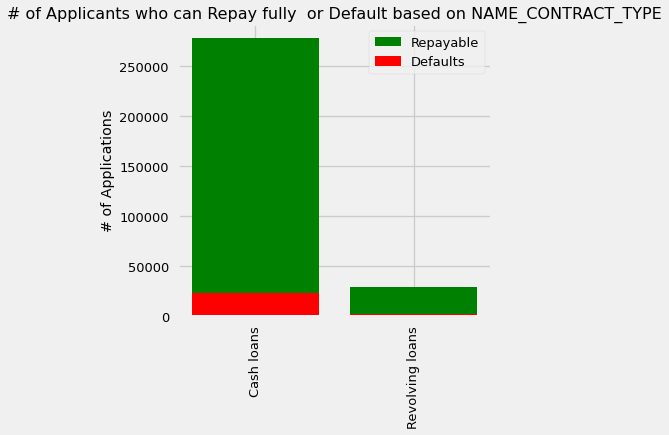

Top 2 records 
  NAME_CONTRACT_TYPE  TARGET   Total   Average
0         Cash loans   23221  278232  0.083459
1    Revolving loans    1604   29279  0.054783
Bottom 2 records 
  NAME_CONTRACT_TYPE  TARGET   Total   Average
0         Cash loans   23221  278232  0.083459
1    Revolving loans    1604   29279  0.054783


In [68]:
contract_type=df_train['NAME_CONTRACT_TYPE'].value_counts()

cash_loans = contract_type[0]
rev_loans = contract_type[1]

print("cash loans = {}".format(cash_loans))
print("revolving loans = {}".format(rev_loans))
print("Proportion of revolving loans to cash loans = {:.2f}%".format((rev_loans / cash_loans)*100 ))

plot_barchart_2columns(data=df_train[['NAME_CONTRACT_TYPE','TARGET']], col1="NAME_CONTRACT_TYPE")

- Observation:
    - It clearly shows customers prefer cash loans more than revolving loans. 

Female = 202448
Male = 105059
Proportion of Male to Female = 51.89%


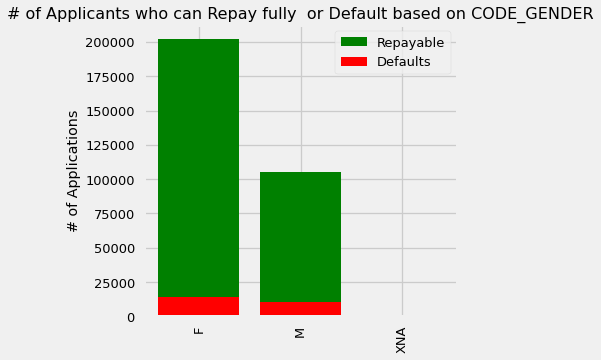

Top 2 records 
  CODE_GENDER  TARGET   Total   Average
0           F   14170  202448  0.069993
1           M   10655  105059  0.101419
Bottom 2 records 
  CODE_GENDER  TARGET   Total   Average
1           M   10655  105059  0.101419
2         XNA       0       4  0.000000


In [69]:
Gender=df_train['CODE_GENDER'].value_counts()

Female = Gender[0]
Male = Gender[1]

print("Female = {}".format(Female))
print("Male = {}".format(Male))
print("Proportion of Male to Female = {:.2f}%".format((Male /Female)*100 ))

plot_barchart_2columns(data=df_train[['CODE_GENDER','TARGET']], col1="CODE_GENDER")

- Observation:
    - Women's are applying more loans than Men. 

OWN Car  = 104587
Doesn't Own Car = 202924
Proportion of Own car to No = 51.54%


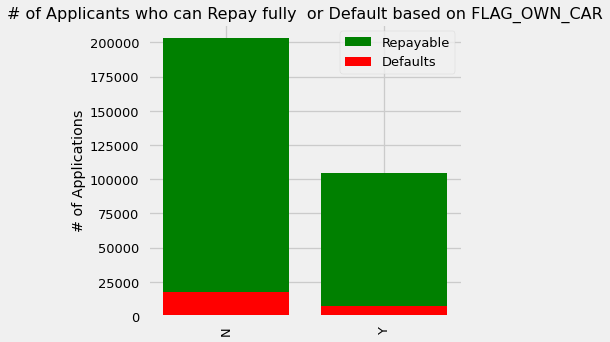

Top 2 records 
  FLAG_OWN_CAR  TARGET   Total   Average
0            N   17249  202924  0.085002
1            Y    7576  104587  0.072437
Bottom 2 records 
  FLAG_OWN_CAR  TARGET   Total   Average
0            N   17249  202924  0.085002
1            Y    7576  104587  0.072437


In [70]:
Own_car=df_train['FLAG_OWN_CAR'].value_counts()

Car_No = Own_car[0]
Car_Yes = Own_car[1]

print("OWN Car  = {}".format(Car_Yes))
print("Doesn't Own Car = {}".format(Car_No))
print("Proportion of Own car to No = {:.2f}%".format((Car_Yes /Car_No)*100 ))

plot_barchart_2columns(data=df_train[['FLAG_OWN_CAR','TARGET']], col1="FLAG_OWN_CAR")

- Observation:
    - Applicants who owns car is 50% closer to not having car.
    - Default ratio who own cars and doesnt own car is more or less same

Own REALTY Yes  = 213312
Own REALTY NO = 94199
Proportion of doesn't own Realty to own = 44.16%


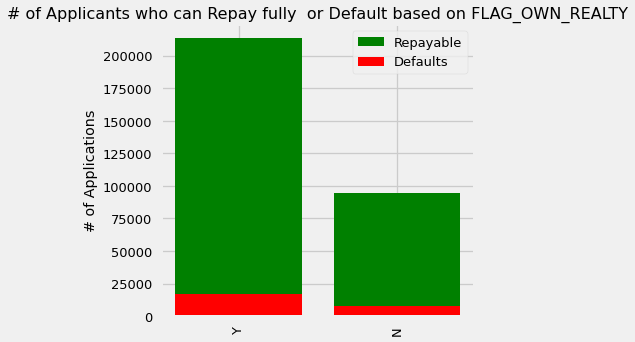

Top 2 records 
  FLAG_OWN_REALTY  TARGET   Total   Average
1               Y   16983  213312  0.079616
0               N    7842   94199  0.083249
Bottom 2 records 
  FLAG_OWN_REALTY  TARGET   Total   Average
1               Y   16983  213312  0.079616
0               N    7842   94199  0.083249


In [71]:
Own_car=df_train['FLAG_OWN_REALTY'].value_counts()

REALTY_No = Own_car[1]
REALTY_Yes = Own_car[0]

print("Own REALTY Yes  = {}".format(REALTY_Yes))
print("Own REALTY NO = {}".format(REALTY_No))
print("Proportion of doesn't own Realty to own = {:.2f}%".format((REALTY_No /REALTY_Yes)*100 ))
plot_barchart_2columns(data=df_train[['FLAG_OWN_REALTY','TARGET']], col1="FLAG_OWN_REALTY")

- Observation:
    - Applicants owns realty have applied loans more than doesn't have realty. It is more than double the time.

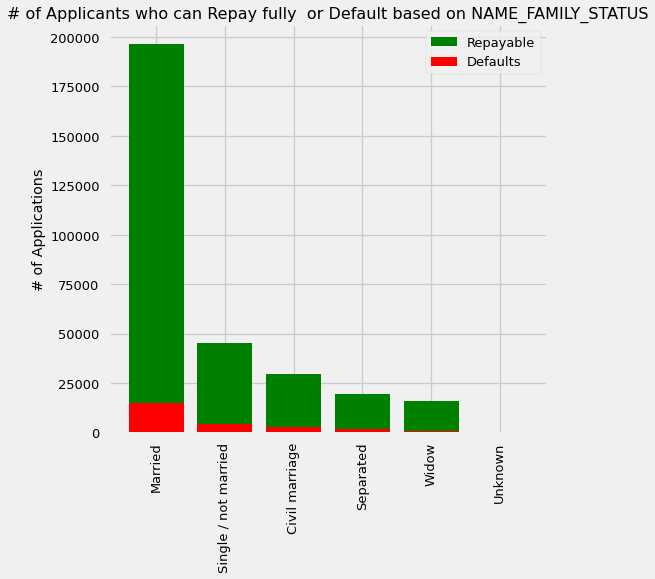

Top 2 records 
     NAME_FAMILY_STATUS  TARGET   Total   Average
1               Married   14850  196432  0.075599
3  Single / not married    4457   45444  0.098077
Bottom 2 records 
  NAME_FAMILY_STATUS  TARGET  Total   Average
5              Widow     937  16088  0.058242
4            Unknown       0      2  0.000000


In [72]:
plot_barchart_2columns(data=df_train[['NAME_FAMILY_STATUS','TARGET']], col1="NAME_FAMILY_STATUS")

- Observation:
    - Married people who have applied loans are very high compare to any other Family status.
    - Widow is very less and unknown category almost negligible

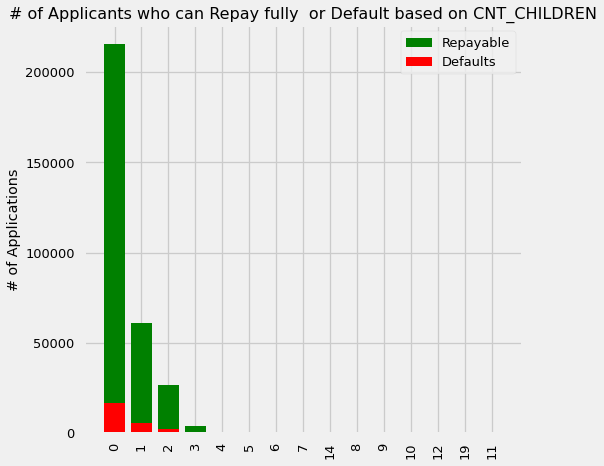

Top 2 records 
   CNT_CHILDREN  TARGET   Total   Average
0             0   16609  215371  0.077118
1             1    5454   61119  0.089236
Bottom 2 records 
    CNT_CHILDREN  TARGET  Total  Average
14            19       0      2      0.0
11            11       1      1      1.0


In [73]:
plot_barchart_2columns(data=df_train[['CNT_CHILDREN','TARGET']], col1="CNT_CHILDREN")

In [74]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =df_train['CNT_CHILDREN'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 0
10 percentile value is 0
20 percentile value is 0
30 percentile value is 0
40 percentile value is 0
50 percentile value is 0
60 percentile value is 0
70 percentile value is 0
80 percentile value is 1
90 percentile value is 2
100 percentile value is  19


In [75]:
#calculating 95-100th percentile to find a the correct percentile value for removal of outliers
for i in range(95,100):
    var =df_train['CNT_CHILDREN'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

95 percentile value is 2
96 percentile value is 2
97 percentile value is 2
98 percentile value is 2
99 percentile value is 3
100 percentile value is  19


In [76]:
#calculating # of children at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =df_train['CNT_CHILDREN'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 3
99.1 percentile value is 3
99.2 percentile value is 3
99.3 percentile value is 3
99.4 percentile value is 3
99.5 percentile value is 3
99.6 percentile value is 3
99.7 percentile value is 3
99.8 percentile value is 3
99.9 percentile value is 4
100 percentile value is  19


- Observation:
    - Either No children or less than 4 have applied more loans.
    - Children having more than 10 is very negligible. 
    - Children 11, 19 are could be Error.  Hence, anything more than 6 children, set it to 6

In [77]:
#remove outliers setting # of children is more than 6 set to max 6
df_train.loc[df_train['CNT_CHILDREN']>6,'CNT_CHILDREN']=6
df_test.loc[df_test['CNT_CHILDREN']>6,'CNT_CHILDREN']=6

#calculating # of Children after removing outliers and  at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =df_train['CNT_CHILDREN'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 3
99.1 percentile value is 3
99.2 percentile value is 3
99.3 percentile value is 3
99.4 percentile value is 3
99.5 percentile value is 3
99.6 percentile value is 3
99.7 percentile value is 3
99.8 percentile value is 3
99.9 percentile value is 4
100 percentile value is  6


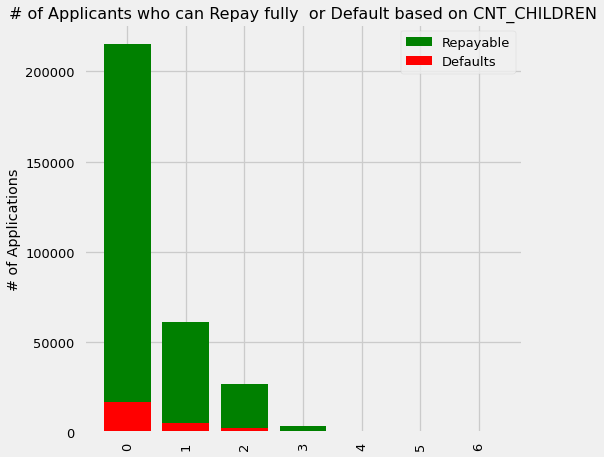

Top 2 records 
   CNT_CHILDREN  TARGET   Total   Average
0             0   16609  215371  0.077118
1             1    5454   61119  0.089236
Bottom 2 records 
   CNT_CHILDREN  TARGET  Total   Average
5             5       7     84  0.083333
6             6       9     42  0.214286


In [78]:
#after removing outlier
plot_barchart_2columns(data=df_train[['CNT_CHILDREN','TARGET']], col1="CNT_CHILDREN")

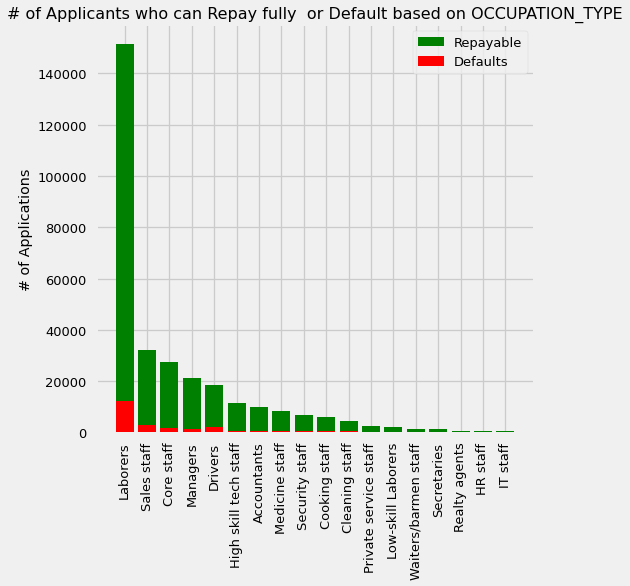

Top 2 records 
   OCCUPATION_TYPE  TARGET   Total   Average
8         Laborers   12116  151577  0.079933
14     Sales staff    3092   32102  0.096318
Bottom 2 records 
  OCCUPATION_TYPE  TARGET  Total   Average
5        HR staff      36    563  0.063943
7        IT staff      34    526  0.064639


In [79]:
plot_barchart_2columns(data=df_train[['OCCUPATION_TYPE','TARGET']], col1="OCCUPATION_TYPE")

In [80]:
def plot_barchart_based_on_feature_and_Applicants_Repay_Yes_No(df,title,xtitle,ytitle):
    feature_value_count=df.value_counts()
    feature_val_y0 = []
    feature_val_y1 = []
    for val in feature_value_count.index:
        feature_val_y1.append(np.sum(df_train['TARGET'][df==val] == 1))
        feature_val_y0.append(np.sum(df_train['TARGET'][df==val] == 0))
    
    plt.close()
    data = [go.Bar(x = feature_value_count.index, y = ((feature_val_y0 / feature_value_count.sum()) * 100), name='Repay' ),
            go.Bar(x = feature_value_count.index, y = ((feature_val_y1 / feature_value_count.sum()) * 100), name='Default' )]
    
    layout = go.Layout(title = xtitle,xaxis=dict(title=xtitle,),yaxis=dict(title=ytitle,), width=700, height=400)

    fig = go.Figure(data = data, layout=layout) 
    fig.layout.template = 'plotly_dark'
    fig.show()
    
    return

#### Another way of plotting 

In [81]:
plot_barchart_based_on_feature_and_Applicants_Repay_Yes_No(df=df_train['NAME_TYPE_SUITE'],
                                                          title="Accompanied with Applicant when applying",
                                                          xtitle='Suite type',
                                                          ytitle='Count of applicants in %')

In [82]:
plot_barchart_based_on_feature_and_Applicants_Repay_Yes_No(df=df_train['NAME_INCOME_TYPE'],
                                                          title="Applicant repaid or not based on the Income Type",
                                                          xtitle='Income type',
                                                          ytitle='Count of applicants in %')

In [83]:
plot_barchart_based_on_feature_and_Applicants_Repay_Yes_No(df=df_train['NAME_EDUCATION_TYPE'],
                                                          title="Applicant repaid or not based on the Education Type",
                                                          xtitle='Education type',
                                                          ytitle='Count of applicants in %')

In [84]:
plot_barchart_based_on_feature_and_Applicants_Repay_Yes_No(df=df_train['NAME_HOUSING_TYPE'],
                                                          title="Applicant repaid or not based on Housing Type",
                                                          xtitle='House Type',
                                                          ytitle='Count of applicants in %')

#### Violin and Box plot to understand the density, percentile and outliers

In [85]:
def plot_violin_boxplot(ds,column):
   #Box-plot can be visualized as a PDF on the side-ways.
    plt.close()
    sns.set_style("whitegrid", {"xtick.major.size": 8, "ytick.major.size": 8});
    fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), constrained_layout=True,sharey=True, sharex=True)
    fig.suptitle("Box and Violin Plot Analysis with "+column)

    
    g=sns.violinplot(x="TARGET", y=ds[column], hue="TARGET", data=ds,  palette='turbo',ax=axes[0])
    g=sns.boxplot(x='TARGET',y=ds[column], hue='TARGET', data=ds,  palette='turbo', ax=axes[1])

    plt.ylabel(column)
    plt.xlabel("TARGET")
    
    labels = [item.get_text() for item in axes[0].get_xticklabels()]
    labels[0] = '0 - Repay'
    labels[1] = '1 - Default'
    axes[0].set_xticklabels(labels)
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles, ['0 - Repay', '1 - Default'], loc='upper center')
    
    labels = [item.get_text() for item in axes[1].get_xticklabels()]
    labels[0] = '0 - Repay'
    labels[1] = '1 - Default'
    axes[1].set_xticklabels(labels)
    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles,['0 - Repay', '1 - Default'],loc='upper center')
    plt.show()
    
    return

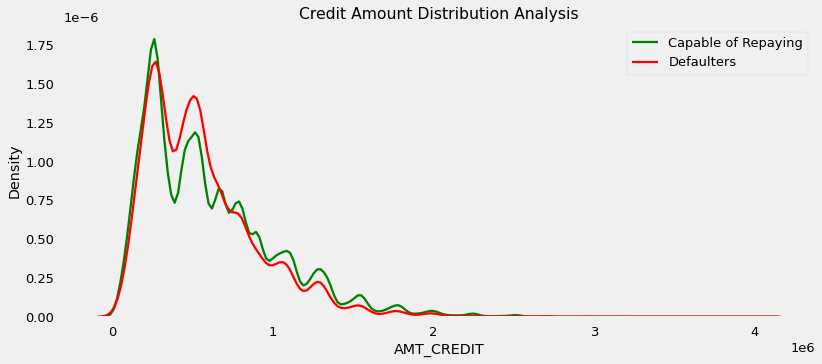

In [86]:
plot_kde_distribution('AMT_CREDIT', 'Credit Amount Distribution Analysis')

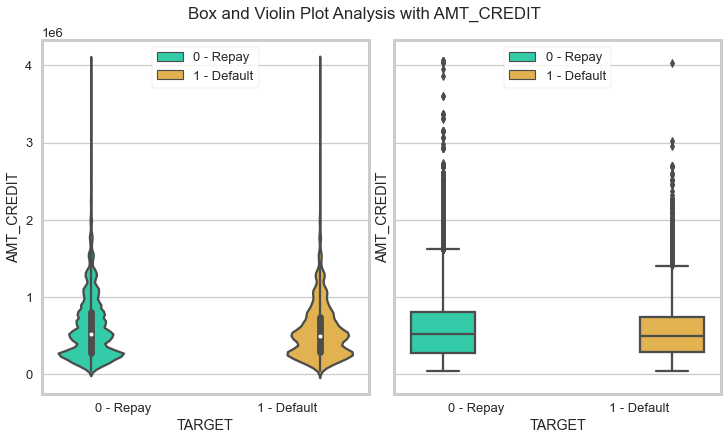

In [87]:
plot_violin_boxplot(df_train[['AMT_CREDIT','TARGET']],'AMT_CREDIT')

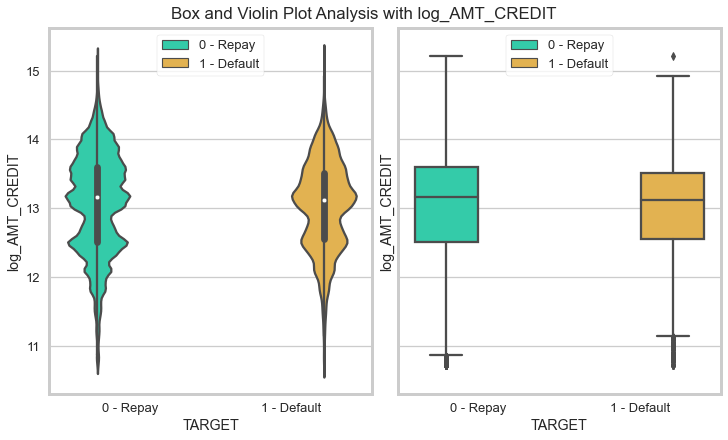

In [88]:
df_train['log_AMT_CREDIT'] = np.log(df_train['AMT_CREDIT'])  
df_test['log_AMT_CREDIT'] = np.log(df_test['AMT_CREDIT'])  

plot_violin_boxplot(df_train[['log_AMT_CREDIT','TARGET']],'log_AMT_CREDIT')

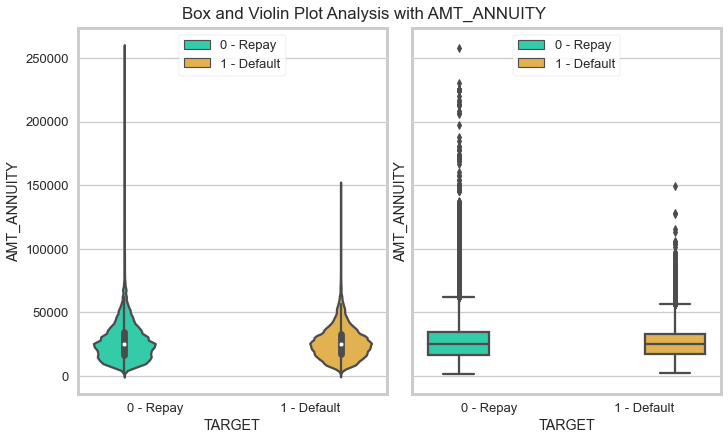

In [89]:
plot_violin_boxplot(df_train[['AMT_ANNUITY','TARGET']],'AMT_ANNUITY')

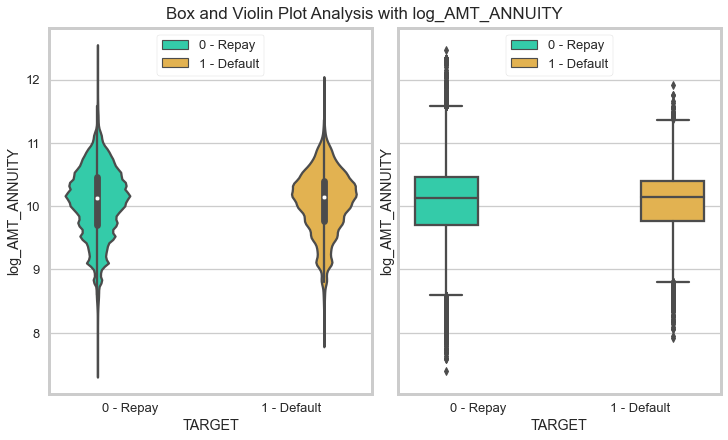

In [90]:
df_train['log_AMT_ANNUITY'] = np.log(df_train['AMT_ANNUITY'])  
df_test['log_AMT_ANNUITY'] = np.log(df_test['AMT_ANNUITY'])  


plot_violin_boxplot(df_train[['log_AMT_ANNUITY','TARGET']],'log_AMT_ANNUITY')

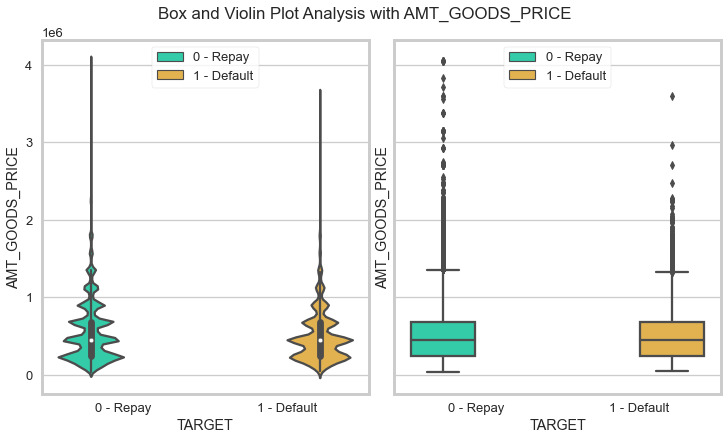

In [91]:
plot_violin_boxplot(df_train[['AMT_GOODS_PRICE','TARGET']],'AMT_GOODS_PRICE')

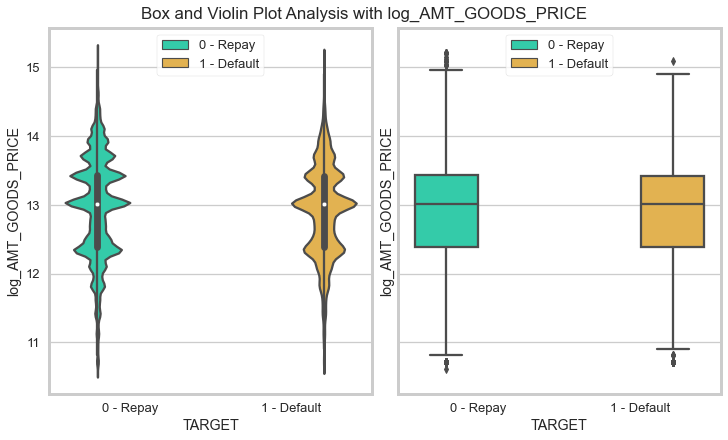

In [92]:
df_train['log_AMT_GOODS_PRICE'] = np.log(df_train['AMT_GOODS_PRICE'])  
df_test['log_AMT_GOODS_PRICE'] = np.log(df_test['AMT_GOODS_PRICE'])  

plot_violin_boxplot(df_train[['log_AMT_GOODS_PRICE','TARGET']],'log_AMT_GOODS_PRICE')

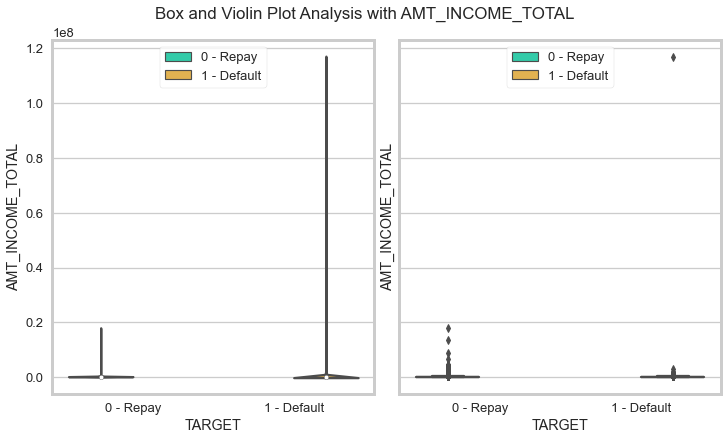

In [93]:
plot_violin_boxplot(df_train[['AMT_INCOME_TOTAL','TARGET']],'AMT_INCOME_TOTAL')

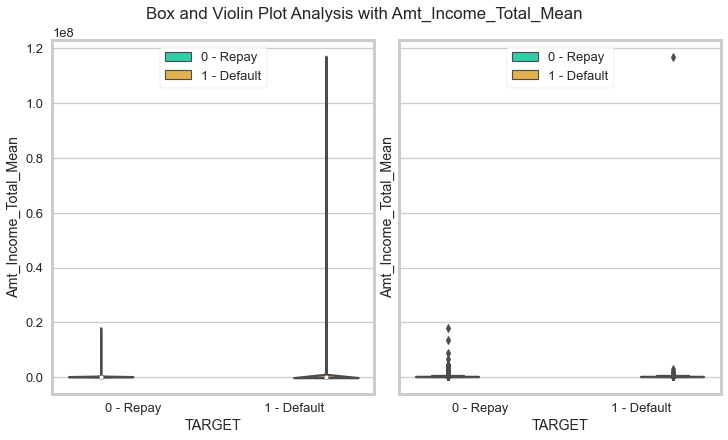

In [94]:
#Credit: https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
df1= df_train.groupby('SK_ID_CURR').agg({'AMT_INCOME_TOTAL':'mean'}).reset_index()
df1.rename(columns = {'AMT_INCOME_TOTAL':'Amt_Income_Total_Mean'}, inplace = True)

df2= df_test.groupby('SK_ID_CURR').agg({'AMT_INCOME_TOTAL':'mean'}).reset_index()
df2.rename(columns = {'AMT_INCOME_TOTAL':'Amt_Income_Total_Mean'}, inplace = True)

df_train=df_train.merge(df1,on='SK_ID_CURR',how='left').reset_index()
df_test=df_test.merge(df2,on='SK_ID_CURR',how='left').reset_index()

plot_violin_boxplot(df_train[['Amt_Income_Total_Mean','TARGET']],'Amt_Income_Total_Mean')

In [95]:
# Remove variables to free memory
gc.enable()
del df1,df2
gc.collect()

7414

- Observations:
    - Based on the violin and box plot, customers repay ratio is  high if the Income < $20,000 

In [96]:

Repay_based_income = df_train[df_train['TARGET']==0]['Amt_Income_Total_Mean'].values
Default_based_income = df_train[df_train['TARGET']==1]['Amt_Income_Total_Mean'].values

x = PrettyTable()
x.field_names = ["Percentile", "Repay based on Income", "Default based on Income"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(Repay_based_income,i), 3),\
               np.round(np.percentile(Default_based_income,i), 3)])
print(x)

+------------+-----------------------+-------------------------+
| Percentile | Repay based on Income | Default based on Income |
+------------+-----------------------+-------------------------+
|     0      |        25650.0        |         25650.0         |
|     5      |        67500.0        |         67500.0         |
|     10     |        81000.0        |         81000.0         |
|     15     |        90000.0        |         90000.0         |
|     20     |        99000.0        |         99000.0         |
|     25     |        112500.0       |         112500.0        |
|     30     |        112500.0       |         112500.0        |
|     35     |        126000.0       |         120873.6        |
|     40     |        135000.0       |         135000.0        |
|     45     |        135000.0       |         135000.0        |
|     50     |        148500.0       |         135000.0        |
|     55     |        157500.0       |         157500.0        |
|     60     |        166

Observations:
- Till the 45th percentile, both the repay and defaulters have almost same value.
- Beyond that, when customer's income increases, Customer Repay percentage increases compare to Defaults.

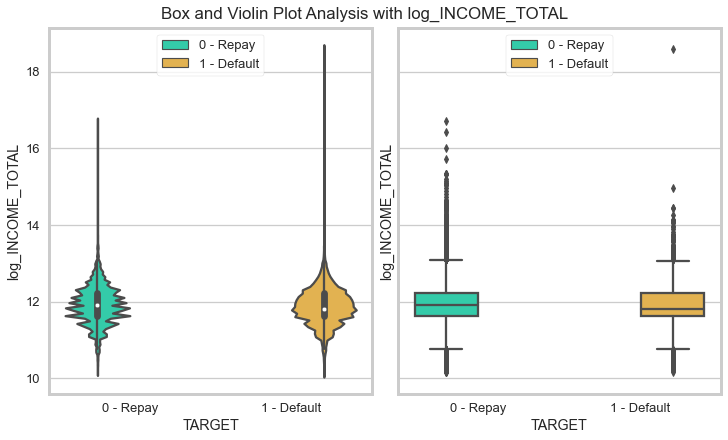

In [97]:
#convert Income Total to log and plot box and violin to check
df_train['log_INCOME_TOTAL'] = np.log(df_train['AMT_INCOME_TOTAL']) 
df_test['log_INCOME_TOTAL'] = np.log(df_test['AMT_INCOME_TOTAL']) 

plot_violin_boxplot(df_train[['log_INCOME_TOTAL','TARGET']],'log_INCOME_TOTAL')

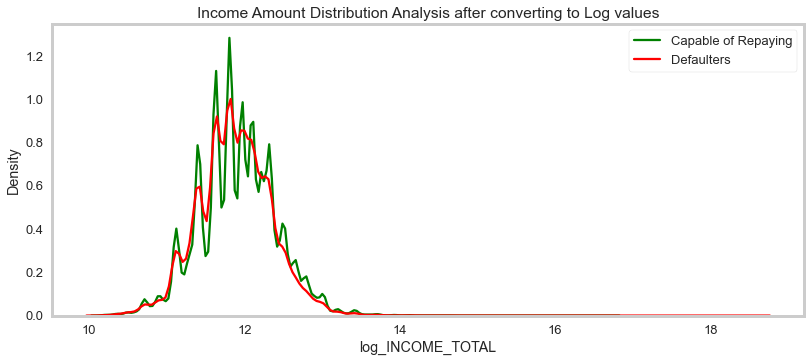

In [98]:
plot_kde_distribution('log_INCOME_TOTAL', 'Income Amount Distribution Analysis after converting to Log values')

In [99]:
# Refer :- https://stackoverflow.com/questions/43643506/select-columns-based-on-columns-names-containing-a-specific-string-in-pandas
df_flag_document = df_train.loc[:, df_train.columns.str.contains('DOCUMENT')]
df_flag_document.head(5)

FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  \
0                0                1                0                0   
1                0                1                0                0   
2                0                0                0                0   
3                0                1                0                0   
4                0                0                0                0   

   FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                1                0   

   FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  FLAG_DOCUMENT_12  FLAG_DOCUMENT_13  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   FLAG_DOCUMENT_14  FLAG_DOCUMENT_15  FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  
0                 0                 0                 0                 0  
1                 0                 0                 0                 0  
2                 0                 0                 0                 0  
3                 0                 0                 0                 0  
4                 0                 0                 0                 0

In [100]:
for column in df_flag_document:
    
    repay = df_flag_document[column].value_counts()[0]
    default = df_flag_document[column].value_counts()[1]
    total_rows = df_flag_document.shape[0]
    
    repay_percentage = np.round((repay*100/total_rows),2)
    default_percentage = np.round(100 - repay_percentage,2)
    
    print(column, "contains percentage of default's = ",repay_percentage,\
    "and percentage of repay's =", default_percentage)

FLAG_DOCUMENT_2 contains percentage of default's =  100.0 and percentage of repay's = 0.0
FLAG_DOCUMENT_3 contains percentage of default's =  29.0 and percentage of repay's = 71.0
FLAG_DOCUMENT_4 contains percentage of default's =  99.99 and percentage of repay's = 0.01
FLAG_DOCUMENT_5 contains percentage of default's =  98.49 and percentage of repay's = 1.51
FLAG_DOCUMENT_6 contains percentage of default's =  91.19 and percentage of repay's = 8.81
FLAG_DOCUMENT_7 contains percentage of default's =  99.98 and percentage of repay's = 0.02
FLAG_DOCUMENT_8 contains percentage of default's =  91.86 and percentage of repay's = 8.14
FLAG_DOCUMENT_9 contains percentage of default's =  99.61 and percentage of repay's = 0.39
FLAG_DOCUMENT_10 contains percentage of default's =  100.0 and percentage of repay's = 0.0
FLAG_DOCUMENT_11 contains percentage of default's =  99.61 and percentage of repay's = 0.39
FLAG_DOCUMENT_12 contains percentage of default's =  100.0 and percentage of repay's = 0.0


- Observation(s):
    - Except Flag 3, Most of the documents are more than 98% of rejected documents. Hence, these informations don't help much. We can remove them.

In [101]:
def drop_columns(df):
    #remove columns 
    df.drop(['FLAG_DOCUMENT_2'],axis=1,inplace=True)
    df.drop(['FLAG_DOCUMENT_4'],axis=1,inplace=True)
    df.drop(['FLAG_DOCUMENT_5'],axis=1,inplace=True)
    df.drop(['FLAG_DOCUMENT_7'],axis=1,inplace=True)
    df.drop(['FLAG_DOCUMENT_9'],axis=1,inplace=True)
    df.drop(['FLAG_DOCUMENT_10'],axis=1,inplace=True)
    df.drop(['FLAG_DOCUMENT_11'],axis=1,inplace=True)
    df.drop(['FLAG_DOCUMENT_12'],axis=1,inplace=True)
    df.drop(['FLAG_DOCUMENT_13'],axis=1,inplace=True)
    df.drop(['FLAG_DOCUMENT_14'],axis=1,inplace=True)
    df.drop(['FLAG_DOCUMENT_15'],axis=1,inplace=True)
    df.drop(['FLAG_DOCUMENT_16'],axis=1,inplace=True)
    df.drop(['FLAG_DOCUMENT_17'],axis=1,inplace=True)
    df.drop(['FLAG_DOCUMENT_18'],axis=1,inplace=True)
    df.drop(['FLAG_DOCUMENT_19'],axis=1,inplace=True)
    df.drop(['FLAG_DOCUMENT_20'],axis=1,inplace=True)
    df.drop(['FLAG_DOCUMENT_21'],axis=1,inplace=True)
    
    return df
df_train = drop_columns(df_train)
df_test = drop_columns(df_test)

#### Multivariate Analysis: Age,Employment, Income_Total, Credit_Amount

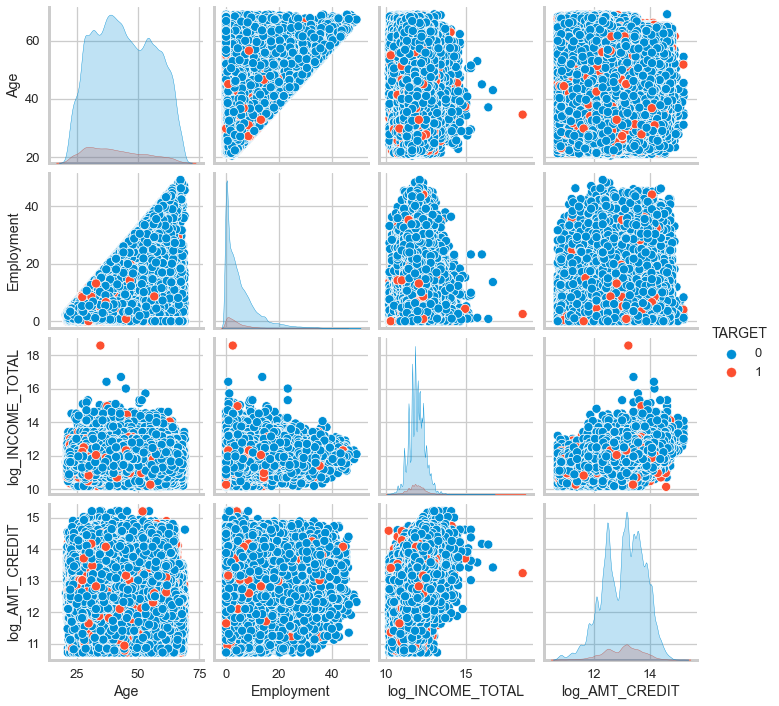

In [102]:
df_train.reset_index()
plt.close()
sns.pairplot(df_train[['TARGET','Age','Employment','log_INCOME_TOTAL',
                       'log_AMT_CREDIT' ]], hue='TARGET')
plt.show()

#### Bivariate Analysis: NAME_CONTRACT_TYPE vs AMT_CREDIT

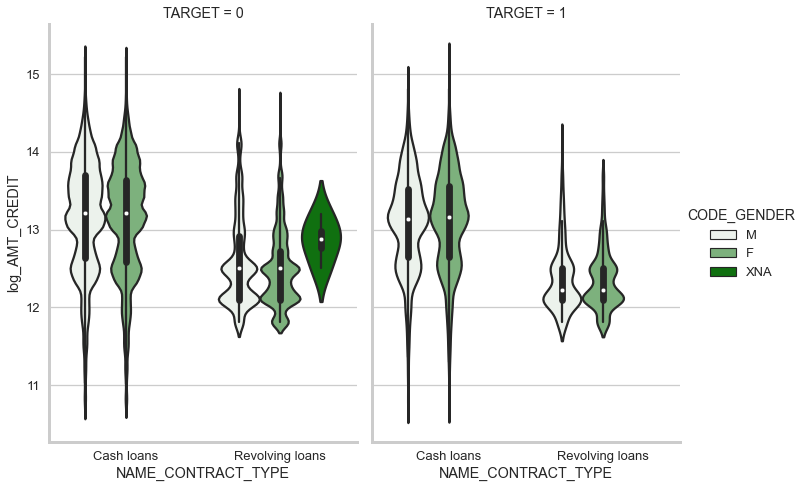

In [103]:
sns.catplot(x="NAME_CONTRACT_TYPE", y="log_AMT_CREDIT", hue="CODE_GENDER" ,col="TARGET",\
            data=df_train,color = "green",kind="violin", height=7, aspect=.7);

- Observations :
    - Both genders(Men and Women) with Cash Loans have higher chances of repaying the loan based on their Credit Amount.

#### Bivariate Analysis: AMT_CREDIT vs NAME_INCOME_TYPE

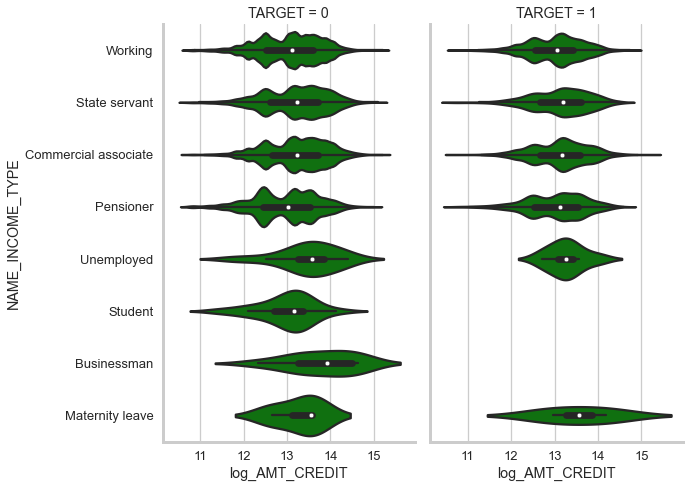

In [104]:
sns.catplot(x="log_AMT_CREDIT", y="NAME_INCOME_TYPE", col="TARGET",\
            data=df_train,color = "green",kind="violin", height=7, aspect=.7);

- Observations :
    - From the above graph, higher credit amount across various income type have higer repaying capabilities, especially  'Unemployed','Student' and 'Businessmen' categories.

####  Bivariate Analysis: AMT_CREDIT vs AMT_INCOME_TOTAL

<AxesSubplot:xlabel='log_AMT_CREDIT', ylabel='log_INCOME_TOTAL'>

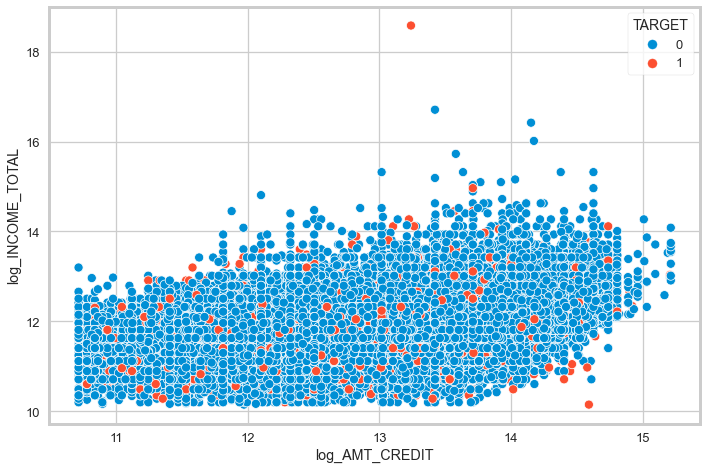

In [105]:
sns.scatterplot(
    data=df_train, x="log_AMT_CREDIT", y="log_INCOME_TOTAL", hue="TARGET",\
    sizes=(20, 200)
)

In [106]:
print("The shape of the train dataset = ",df_train.shape)
df_train['Age'].describe()

The shape of the train dataset =  (307511, 116)


count    307511.00000
mean              NaN
std           0.00000
min          20.50000
25%          34.00000
50%          43.18750
75%          53.90625
max          69.12500
Name: Age, dtype: float64

In [107]:
print("The minimum age across all applicants (in years) = {:.2f} ".format(min(df_train['Age'].values)))

print("The maximum age across all applicants (in years) = {:.2f} ".format(max(df_train['Age'].values)))

The minimum age across all applicants (in years) = 20.50 
The maximum age across all applicants (in years) = 69.12 


In [108]:
df_train['Employment'].describe()

count    307511.000000
mean               NaN
std           0.000000
min           0.000000
25%           0.799805
50%           3.300781
75%           7.601562
max          49.093750
Name: Employment, dtype: float64

In [109]:
print("The minimum Employment across all applicants (in years) = {:.2f} ".format(min(df_train['Employment'].values)))

print("The maximum Employment across all applicants (in years) = {:.2f} ".format(max(df_train['Employment'].values)))

The minimum Employment across all applicants (in years) = 0.00 
The maximum Employment across all applicants (in years) = 49.09 


- Observation:
    - Seems all AMOUNT columns are highly skewed data and convert them to Log values 

In [110]:
amt_columns =[NC for NC in numerical_columns if 'AMT' in NC]
amt_columns

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

- Observation:
 - columns 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE' are converted to log values
 - columns 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR' are not skewed and hence left as it is. 

In [111]:
df_train = reduce_memory_usage(df_train )
print('Number of data points : ', df_train.shape[0])
print('Number of features : ', df_train.shape[1])

print("="*50)
df_test = reduce_memory_usage(df_test )
print('Number of data points : ', df_test.shape[0])
print('Number of features : ', df_test.shape[1])

Memory usage of dataframe is 97.95 MB
Memory usage after optimization is: 94.43 MB
Decreased by 3.6%
Number of data points :  307511
Number of features :  116
Memory usage of dataframe is 15.48 MB
Memory usage after optimization is: 14.92 MB
Decreased by 3.6%
Number of data points :  48744
Number of features :  115


In [112]:
df_train1=df_train.copy(deep=True)
df_test1 = df_test.copy(deep=True)

In [113]:
#df_train=df_train1.copy(deep=True)
#df_test = df_test1.copy(deep=True)

In [114]:

#Try to add some more features domain based
# Credit :- https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction#Feature-Engineering
epsilon=0.001 # to avoid div/0 error 
def Feature_Engineering(df):
    df1 = pd.DataFrame()
    df1['SK_ID_CURR']=df['SK_ID_CURR']
    
    df1['pc_Credit_Income'] = np.round((df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL']+epsilon)),4)
    df1['pc_Annuity_Income'] = np.round((df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL']+epsilon)),4)
    df1['pc_Credit_Annuity'] = np.round((df['AMT_CREDIT'] / (df['AMT_ANNUITY']+epsilon)),4)
    df1['Crdit_Goods_Diff'] = df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']
    df1['CREDIT_TERM'] = np.round((df['AMT_ANNUITY'] / (df['AMT_CREDIT']+epsilon)),4)
    df1['pc_Employment_Age'] = np.round((df['Employment'] / (df['Age']+epsilon)),4)
    #df1['pc_Income_Children'] = np.round((df['AMT_INCOME_TOTAL']/(df['CNT_CHILDREN']+epsilon)),4)
    #df1['pc_Employment_Registration'] = np.round(((df['Employment']+epsilon) / (df['Registration_Years']+epsilon)),4)
    #df1['pc_Age_Registration'] = np.round(((df['Age']+epsilon) / (df['Registration_Years']+epsilon)),4)
    #df1['ID_REGISTRATION_DIFF'] = df['Id_Publish_Years'] - df['Registration_Years']
    #df1['pc_Term_Employment'] = np.round((df1['CREDIT_TERM']/ (df['Employment']+epsilon)),4)
    #df1['Age_Loan_Finish'] = np.round((df['Age'] + (df['AMT_CREDIT']/(df['AMT_ANNUITY']+epsilon))),4)
    #df1['pc_Phone_Employment'] = np.round((df['Phone_change_Years']/df['Employment']),4)
    #df1['pc_Phone_Age'] = np.round((df['Phone_change_Years']/df['Age']),4)
    return df1
df2=Feature_Engineering(df_train)
df3=Feature_Engineering(df_test)
df_train = df_train.merge(df2, on = 'SK_ID_CURR', how = 'left')
df_test = df_test.merge(df3, on = 'SK_ID_CURR', how = 'left')

print('Train data after Feature Engineering ~>{}'.format(df_train1.shape))
print('Test data after Feature Engineering ~>{}'.format(df_test1.shape))

Train data after Feature Engineering ~>(307511, 116)
Test data after Feature Engineering ~>(48744, 115)


In [115]:
# Merge new features into main dataframe
gc.enable()
del df2,df3
gc.collect()

67913

In [116]:
df_train['EXT_SOURCE_2']=df_train['EXT_SOURCE_2'].round(decimals=4)
df_train['EXT_SOURCE_3']=df_train['EXT_SOURCE_3'].round(decimals=4)
#Test
df_test['EXT_SOURCE_2']=df_test['EXT_SOURCE_2'].round(decimals=4)
df_test['EXT_SOURCE_3']=df_test['EXT_SOURCE_3'].round(decimals=4)

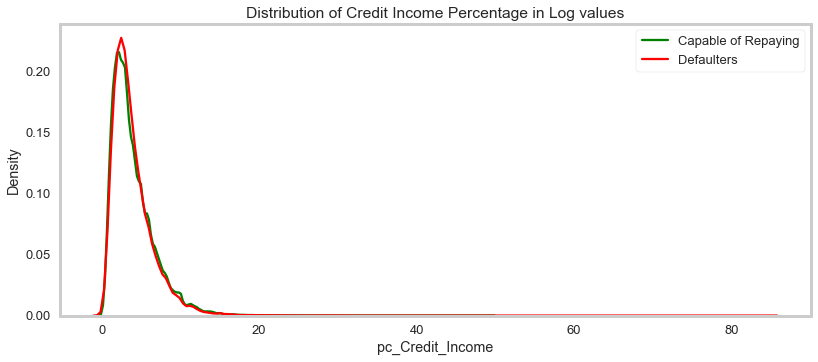

In [117]:
plot_kde_distribution('pc_Credit_Income', 'Distribution of Credit Income Percentage in Log values')

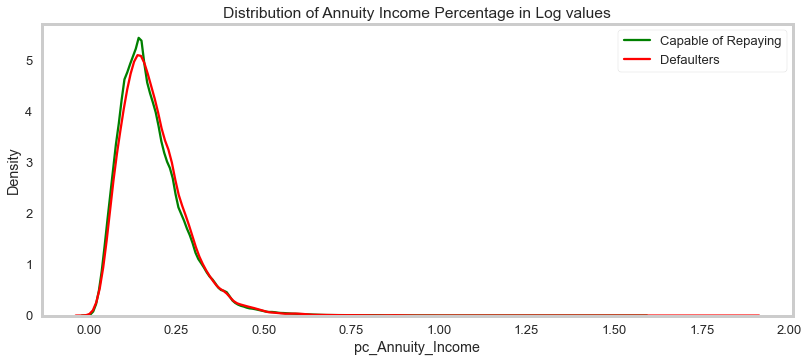

In [118]:
plot_kde_distribution('pc_Annuity_Income', 'Distribution of Annuity Income Percentage in Log values')

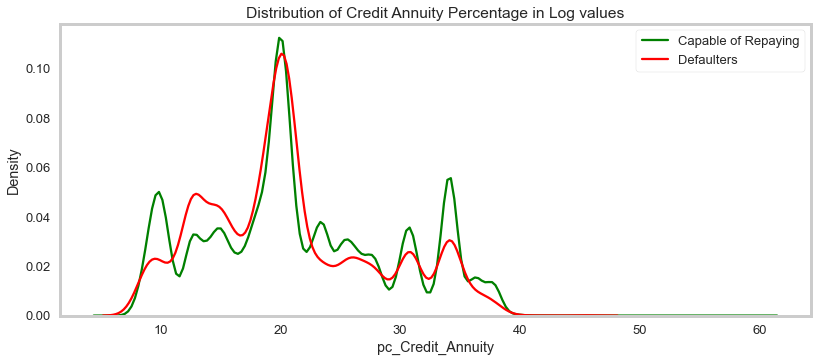

In [119]:
plot_kde_distribution('pc_Credit_Annuity', 'Distribution of Credit Annuity Percentage in Log values')

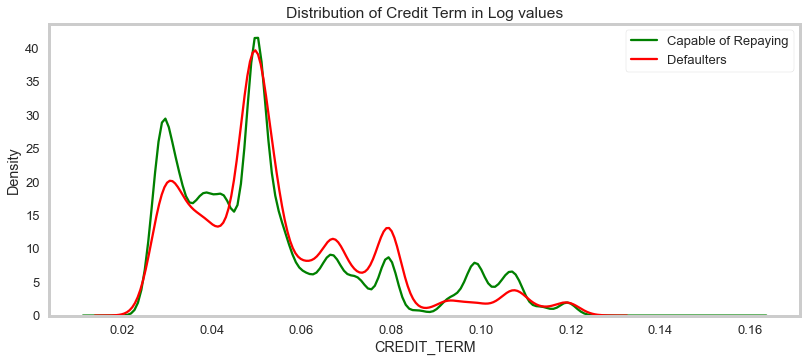

In [120]:
plot_kde_distribution('CREDIT_TERM', 'Distribution of Credit Term in Log values')

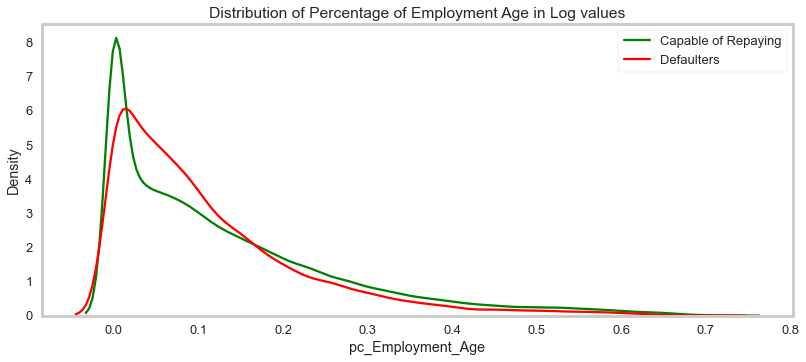

In [121]:
plot_kde_distribution('pc_Employment_Age', 'Distribution of Percentage of Employment Age in Log values')

In [122]:
#RuntimeWarning: overflow encountered in multiply
#while transforming the below features to polinomial, runtime overflow occurs
#to avoid, convert all of them to float64
df_train['EXT_SOURCE_1'] = df_train['EXT_SOURCE_1'].astype(np.float64)
df_train['EXT_SOURCE_2'] = df_train['EXT_SOURCE_2'].astype(np.float64)
df_train['EXT_SOURCE_3'] = df_train['EXT_SOURCE_3'].astype(np.float64)
df_train['Age'] = df_train['Age'].astype(np.float64)
df_train['Employment'] = df_train['Employment'].astype(np.float64)
#df_train['pc_Employment_Registration'] = df_test['pc_Employment_Registration'].astype(np.float64)

df_test['EXT_SOURCE_1'] = df_test['EXT_SOURCE_1'].astype(np.float64)
df_test['EXT_SOURCE_2'] = df_test['EXT_SOURCE_2'].astype(np.float64)
df_test['EXT_SOURCE_3'] = df_test['EXT_SOURCE_3'].astype(np.float64)
df_test['Age'] = df_test['Age'].astype(np.float64)
df_test['Employment'] = df_test['Employment'].astype(np.float64)
#df_test['pc_Employment_Registration'] = df_test['pc_Employment_Registration'].astype(np.float64)

In [123]:
# Try to add some polinomial features

# Make a new dataframe for polynomial features
#credit: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction#Feature-Engineering
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

# Generate a new feature matrix consisting of all polynomial combinations of the features with degree less than 
# or equal to the specified degree. For example, if an input sample is two dimensional and of the form [a, b], 
# the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].

# imputer for handling missing values
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')


poly_features = df_train[['SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3', 'Age', 'Employment','TARGET']]
poly_features_test = df_test[['SK_ID_CURR', 'EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3', 'Age','Employment']]

poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features[['EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3', 'Age','Employment']])
#testing data only transformed.
poly_features_test = imputer.transform(poly_features_test[['EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3', 'Age','Employment']])

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)


# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features for both test and train
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 56)


In [125]:
poly_features = pd.DataFrame(poly_features, 
                            columns = poly_transformer.get_feature_names(
                                            input_features = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3', 'Age','Employment']))
poly_features['SK_ID_CURR'] = df_train['SK_ID_CURR']

# Merge polynomial features into training dataframe
df_train = df_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

In [127]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                            columns = poly_transformer.get_feature_names(
                                            input_features = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3', 'Age','Employment']))

poly_features_test['SK_ID_CURR'] = df_test['SK_ID_CURR']

# Merge polnomial features into testing dataframe
df_test = df_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')


In [128]:
print(df_train.shape)
print(df_test.shape)

(307511, 178)
(48744, 177)


In [129]:
categorical_columns=df_train.select_dtypes(include=object).columns.to_list()
print('# of Categorical columns~~> {}'.format(len(categorical_columns)))

# of Categorical columns~~> 16


In [130]:
x = PrettyTable()
x.field_names = ["column", "# of categorical values"]

#Now check does any of the categorical feature, have more number of categorical. 
for idx,col in enumerate(categorical_columns):
    df=pd.DataFrame(df_train[col].value_counts())
    x.add_row([col,len(df.index)])
    
x.sortby="# of categorical values"
x.reversesort=True
print(x)

+----------------------------+-------------------------+
|           column           | # of categorical values |
+----------------------------+-------------------------+
|     ORGANIZATION_TYPE      |            58           |
|      OCCUPATION_TYPE       |            18           |
|      NAME_INCOME_TYPE      |            8            |
| WEEKDAY_APPR_PROCESS_START |            7            |
|     WALLSMATERIAL_MODE     |            7            |
|      NAME_TYPE_SUITE       |            7            |
|     NAME_HOUSING_TYPE      |            6            |
|     NAME_FAMILY_STATUS     |            6            |
|    NAME_EDUCATION_TYPE     |            5            |
|     FONDKAPREMONT_MODE     |            4            |
|       HOUSETYPE_MODE       |            3            |
|        CODE_GENDER         |            3            |
|     NAME_CONTRACT_TYPE     |            2            |
|      FLAG_OWN_REALTY       |            2            |
|        FLAG_OWN_CAR        | 

- Observation:
    - Since ORGANIZATION_TYPE column has 58 categorical values, hard to use BOW or one hot encoding. 
    - Will use response encoding for categorical features

In [131]:
df_train['pc_Employment_Age'].replace([np.inf, -np.inf], 0.0001, inplace=True)
df_test['pc_Employment_Age'].replace([np.inf, -np.inf], 0.0001, inplace=True)

#df_train['pc_Employment_Registration'].replace([np.inf, -np.inf], 0.0001, inplace=True)
#df_test['pc_Employment_Registration'].replace([np.inf, -np.inf], 0.0001, inplace=True)

In [132]:
#drop columns 
df_train.drop(['AMT_CREDIT'],axis=1,inplace=True)
df_test.drop(['AMT_CREDIT'],axis=1,inplace=True)

df_train.drop(['AMT_ANNUITY'],axis=1,inplace=True)
df_test.drop(['AMT_ANNUITY'],axis=1,inplace=True)

df_train.drop(['AMT_GOODS_PRICE'],axis=1,inplace=True)
df_test.drop(['AMT_GOODS_PRICE'],axis=1,inplace=True)


df_train.drop(['AMT_INCOME_TOTAL'],axis=1,inplace=True)
df_test.drop(['AMT_INCOME_TOTAL'],axis=1,inplace=True)

In [133]:
#drop these columns from test dataset
df_test.drop(['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_LAST_PHONE_CHANGE','DAYS_REGISTRATION','DAYS_ID_PUBLISH'],axis=1,inplace=True)
#drop these columns from train dataset
df_train.drop(['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_LAST_PHONE_CHANGE','DAYS_REGISTRATION','DAYS_ID_PUBLISH'],axis=1,inplace=True)


In [134]:
df_train1=df_train.copy(deep=True)
df_test1=df_test.copy(deep=True)

In [135]:
#df_train.shape

In [136]:
#df_train=df_train1.copy(deep=True)
#df_test=df_test1.copy(deep=True)

#### Merge Bureau, Bureau Balance to Train

In [137]:
df_bureau = reduce_memory_usage( pd.read_csv('./data/bureau.csv', encoding= 'unicode_escape'))
print('Number of data points : ', df_bureau.shape[0])
print('Number of features : ', df_bureau.shape[1])
df_bureau.head(1)

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%
Number of data points :  1716428
Number of features :  17


SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN

In [138]:
# check df_bureau columns has missing data more than 80
#print # of columns in df_bureau before removing
print('# of columns before removing in df_bureau ~> {}'.format(df_bureau.shape[1]))
#drop columns
df_bureau =remove_missing_columns(df_bureau,threshold=80)
#print # of columns in df_bureau before removing
print('# of columns after removing in df_bureau ~> {}'.format(df_bureau.shape[1]))

# of columns before removing in df_bureau ~> 17
There are 0 columns with greater than 80% missing values.
# of columns after removing in df_bureau ~> 17


In [139]:
num_columns=df_bureau.select_dtypes(exclude=object).columns.to_list()
print('# of Numerical columns in Bureau~~> {}'.format(len(num_columns)))

cat_columns=df_bureau.select_dtypes(include=object).columns.to_list()
print('# of categorical columns in Bureau~~> {}'.format(len(cat_columns)))

# of Numerical columns in Bureau~~> 14
# of categorical columns in Bureau~~> 3


In [140]:
cat_columns

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

In [141]:
df_bureau['CREDIT_ACTIVE'].value_counts()

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64

In [142]:
#fix all categorical values with most frequent values.
df_bureau =  fill_mostfrequent_value(df_bureau)

In [143]:
cat_col=['SK_ID_CURR','CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

In [144]:
# get application level STATUS
# groupby SK_ID_CURR head(1) will give application level status
df_bureau_categorical_group =df_bureau[cat_col].groupby('SK_ID_CURR').head(1).reset_index(drop=True)
df_bureau_categorical_group.head(1)
df_train=df_train.merge(df_bureau_categorical_group,on='SK_ID_CURR', how='left' )
df_train=fill_mostfrequent_value(df_train)
df_test=df_test.merge(df_bureau_categorical_group,on='SK_ID_CURR', how='left' )
df_test=fill_mostfrequent_value(df_test)

In [145]:
print(df_train.shape)
print(df_test.shape)

(307511, 172)
(48744, 171)


In [146]:
day_columns =[NC for NC in num_columns if 'DAY' in NC]
day_columns

['DAYS_CREDIT',
 'CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'DAYS_CREDIT_UPDATE']

In [147]:
#since DAYS_CREDIT_ENDDATE has both negative and positve values. 
#assuming that positive values are Error and set to zero
df_bureau.loc[df_bureau['DAYS_CREDIT_ENDDATE']>0,'DAYS_CREDIT_ENDDATE']=0
#after this convert them into Years 
df_bureau.loc[df_bureau['DAYS_CREDIT_UPDATE']>0,'DAYS_CREDIT_UPDATE']=0
#after this convert them into Years 

In [148]:
#fix all days column with Years.
df_bureau['Years_Credit'] = convert_negative_days_year(df_bureau['DAYS_CREDIT'])
#since overdue doesn't have negative values, convert them into years only.
df_bureau['Years_Credit_Overdue'] = df_bureau['CREDIT_DAY_OVERDUE']/365.0  #convert them into float
df_bureau['Years_Credit_EndDate'] = convert_negative_days_year(df_bureau['DAYS_CREDIT_ENDDATE'])
df_bureau['Years_EndDate_Fact'] = convert_negative_days_year(df_bureau['DAYS_ENDDATE_FACT'])
df_bureau['Years_Credit_Update'] = convert_negative_days_year(df_bureau['DAYS_CREDIT_UPDATE'])

In [149]:
df_bureau.drop(['DAYS_CREDIT'], axis=1, inplace=True)
df_bureau.drop(['CREDIT_DAY_OVERDUE'], axis=1, inplace=True)
df_bureau.drop(['DAYS_CREDIT_ENDDATE'], axis=1, inplace=True)
df_bureau.drop(['DAYS_ENDDATE_FACT'], axis=1, inplace=True)
df_bureau.drop(['DAYS_CREDIT_UPDATE'], axis=1, inplace=True)

In [150]:
amt_columns =[NC for NC in num_columns if 'AMT' in NC]
amt_columns

['AMT_CREDIT_MAX_OVERDUE',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'AMT_ANNUITY']

In [151]:
df_bureau['AMT_ANNUITY'].min()

0.0

In [152]:
#since AMT_CREDIT_SUM_DEBT has both negative and positve values. 
#Amount cant have negative values. Hence set negative values to 0.01 
# To convert log setting it to 0.01
df_bureau.loc[df_bureau['AMT_CREDIT_MAX_OVERDUE']<=0,'AMT_CREDIT_MAX_OVERDUE']=0.01
df_bureau.loc[df_bureau['AMT_CREDIT_SUM']<=0,'AMT_CREDIT_SUM']=0.01
df_bureau.loc[df_bureau['AMT_CREDIT_SUM_DEBT']<=0,'AMT_CREDIT_SUM_DEBT']=0.01
df_bureau.loc[df_bureau['AMT_CREDIT_SUM_LIMIT']<=0,'AMT_CREDIT_SUM_LIMIT']=0.01
df_bureau.loc[df_bureau['AMT_CREDIT_SUM_OVERDUE']<=0,'AMT_CREDIT_SUM_OVERDUE']=0.01
df_bureau.loc[df_bureau['AMT_ANNUITY']<=0,'AMT_ANNUITY']=0.01
#before converting them to log values fix with median values.

In [153]:
#fix all numeric values with median values.
df_bureau =  fill_median_value(df_bureau)

In [154]:
#convert all Amount values with log values
df_bureau['log_CREDIT_MAX_OVERDUE']=np.log(df_bureau['AMT_CREDIT_MAX_OVERDUE'])
df_bureau['log_CREDIT_SUM']=np.log(df_bureau['AMT_CREDIT_SUM'])
df_bureau['log_CREDIT_SUM_DEBT']=np.log(df_bureau['AMT_CREDIT_SUM_DEBT'])
df_bureau['log_CREDIT_SUM_LIMIT']=np.log(df_bureau['AMT_CREDIT_SUM_LIMIT'])
df_bureau['log_CREDIT_SUM_OVERDUE']=np.log(df_bureau['AMT_CREDIT_SUM_OVERDUE'])
df_bureau['log_ANNUITY']=np.log(df_bureau['AMT_ANNUITY'])

#### Statistical Columns [Aggregating Mean,Count,Min,Max and Sum Columns] for Numerical features

In [155]:
# we will put together all above bureau functions, into one function. So that, we can use it for 
# other dataframes
# credit:https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering
def numeric_aggregate(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

#### Create stats columns on categorical features [count and normalized count]

In [156]:
# calculate the counts and normalized counts of each category for all categorical variables in the dataframe.
# very similar to numeric_aggregate
## credit:https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering

def feature_engineering_categorical_variables(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [157]:
# Group by the applicant id, calculate aggregation statistics
df_bureau_agg = numeric_aggregate(df_bureau.drop(columns = ['SK_ID_BUREAU']),group_var = 'SK_ID_CURR', df_name = 'bureau')
df_bureau_agg.head(1)

SK_ID_CURR  bureau_AMT_CREDIT_MAX_OVERDUE_count  \
0      100001                                    7   

   bureau_AMT_CREDIT_MAX_OVERDUE_mean  bureau_AMT_CREDIT_MAX_OVERDUE_max  \
0                                0.01                               0.01   

   bureau_AMT_CREDIT_MAX_OVERDUE_min  bureau_AMT_CREDIT_MAX_OVERDUE_sum  \
0                               0.01                               0.07   

   bureau_CNT_CREDIT_PROLONG_count  bureau_CNT_CREDIT_PROLONG_mean  \
0                                7                             0.0   

   bureau_CNT_CREDIT_PROLONG_max  bureau_CNT_CREDIT_PROLONG_min  \
0                              0                              0   

   bureau_CNT_CREDIT_PROLONG_sum  bureau_AMT_CREDIT_SUM_count  \
0                              0                            7   

   bureau_AMT_CREDIT_SUM_mean  bureau_AMT_CREDIT_SUM_max  \
0               207623.578125                   378000.0   

   bureau_AMT_CREDIT_SUM_min  bureau_AMT_CREDIT_SUM_sum  \
0                    85500.0                  1453365.0   

   bureau_AMT_CREDIT_SUM_DEBT_count  bureau_AMT_CREDIT_SUM_DEBT_mean  \
0                                 7                       85240.9375   

   bureau_AMT_CREDIT_SUM_DEBT_max  bureau_AMT_CREDIT_SUM_DEBT_min  \
0                        373239.0                            0.01   

   bureau_AMT_CREDIT_SUM_DEBT_sum  bureau_AMT_CREDIT_SUM_LIMIT_count  \
0                     596686.5625                                  7   

   bureau_AMT_CREDIT_SUM_LIMIT_mean  bureau_AMT_CREDIT_SUM_LIMIT_max  \
0                              0.01                             0.01   

   bureau_AMT_CREDIT_SUM_LIMIT_min  bureau_AMT_CREDIT_SUM_LIMIT_sum  \
0                             0.01                             0.07   

   bureau_AMT_CREDIT_SUM_OVERDUE_count  bureau_AMT_CREDIT_SUM_OVERDUE_mean  \
0                                    7                                0.01   

   bureau_AMT_CREDIT_SUM_OVERDUE_max  bureau_AMT_CREDIT_SUM_OVERDUE_min  \
0                               0.01                               0.01   

   bureau_AMT_CREDIT_SUM_OVERDUE_sum  bureau_AMT_ANNUITY_count  \
0                               0.07                         7   

   bureau_AMT_ANNUITY_mean  bureau_AMT_ANNUITY_max  bureau_AMT_ANNUITY_min  \
0              3545.362793                 10822.5                    0.01   

   bureau_AMT_ANNUITY_sum  bureau_Years_Credit_count  \
0            24817.539062                          7   

   bureau_Years_Credit_mean  bureau_Years_Credit_max  bureau_Years_Credit_min  \
0                       2.0                      4.3                      0.1   

   bureau_Years_Credit_sum  bureau_Years_Credit_Overdue_count  \
0                     14.0                                  7   

   bureau_Years_Credit_Overdue_mean  bureau_Years_Credit_Overdue_max  \
0                               0.0                              0.0   

   bureau_Years_Credit_Overdue_min  bureau_Years_Credit_Overdue_sum  \
0                              0.0                              0.0   

   bureau_Years_Credit_EndDate_count  bureau_Years_Credit_EndDate_mean  \
0                                  7                          0.971429   

   bureau_Years_Credit_EndDate_max  bureau_Years_Credit_EndDate_min  \
0                              3.6                              0.0   

   bureau_Years_Credit_EndDate_sum  bureau_Years_EndDate_Fact_count  \
0                              6.8                                7   

   bureau_Years_EndDate_Fact_mean  bureau_Years_EndDate_Fact_max  \
0                        2.357143                            3.6   

   bureau_Years_EndDate_Fact_min  bureau_Years_EndDate_Fact_sum  \
0                            1.5                           16.5   

   bureau_Years_Credit_Update_count  bureau_Years_Credit_Update_mean  \
0                                 7                         0.228571   

   bureau_Years_Credit_Update_max  bureau_Years_Credit_Update_min  \
0           

In [158]:
df_bureau_categorical = feature_engineering_categorical_variables(df=df_bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
df_bureau_categorical.head(1)

bureau_CREDIT_ACTIVE_Active_count  \
SK_ID_CURR                                      
100001                                      3   

            bureau_CREDIT_ACTIVE_Active_count_norm  \
SK_ID_CURR                                           
100001                                    0.428571   

            bureau_CREDIT_ACTIVE_Bad debt_count  \
SK_ID_CURR                                        
100001                                        0   

            bureau_CREDIT_ACTIVE_Bad debt_count_norm  \
SK_ID_CURR                                             
100001                                           0.0   

            bureau_CREDIT_ACTIVE_Closed_count  \
SK_ID_CURR                                      
100001                                      4   

            bureau_CREDIT_ACTIVE_Closed_count_norm  \
SK_ID_CURR                                           
100001                                    0.571429   

            bureau_CREDIT_ACTIVE_Sold_count  \
SK_ID_CURR                                    
100001                                    0   

            bureau_CREDIT_ACTIVE_Sold_count_norm  \
SK_ID_CURR                                         
100001                                       0.0   

            bureau_CREDIT_CURRENCY_currency 1_count  \
SK_ID_CURR                                            
100001                                            7   

            bureau_CREDIT_CURRENCY_currency 1_count_norm  \
SK_ID_CURR                                                 
100001                                               1.0   

            bureau_CREDIT_CURRENCY_currency 2_count  \
SK_ID_CURR                                            
100001                                            0   

            bureau_CREDIT_CURRENCY_currency 2_count_norm  \
SK_ID_CURR                                                 
100001                                               0.0   

            bureau_CREDIT_CURRENCY_currency 3_count  \
SK_ID_CURR                                            
100001                                            0   

            bureau_CREDIT_CURRENCY_currency 3_count_norm  \
SK_ID_CURR                                                 
100001                                               0.0   

            bureau_CREDIT_CURRENCY_currency 4_count  \
SK_ID_CURR                                            
100001                                            0   

            bureau_CREDIT_CURRENCY_currency 4_count_norm  \
SK_ID_CURR                                                 
100001                                               0.0   

            bureau_CREDIT_TYPE_Another type of loan_count  \
SK_ID_CURR                                                  
100001                                                  0   

            bureau_CREDIT_TYPE_Another type of loan_count_norm  \
SK_ID_CURR                                                       
100001                                                    0.0    

            bureau_CREDIT_TYPE_Car loan_count  \
SK_ID_CURR                                      
100001                                      0   

            bureau_CREDIT_TYPE_Car loan_count_norm  \
SK_ID_CURR                                           
100001                                         0.0   

            bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count  \
SK_ID_CURR                                                       
100001                                                      0    

            bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count_norm  \
SK_ID_CURR                                                            
100001                                                    0.0         

            bureau_CREDIT_TYPE_Consumer credit_count  \
SK_ID_CURR                                             
100001                                             7   

            bureau_CREDIT_TYPE_Consumer credit_count_norm  \
SK_ID_CURR                                 

In [159]:
df_bureau_categorical.shape

(305811, 46)

In [160]:
df_bureau_agg.shape

(305811, 91)

In [161]:
# Merge with the training data
df_train = df_train.merge(df_bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the testing data
df_test = df_test.merge(df_bureau_agg, on = 'SK_ID_CURR', how = 'left')


In [162]:
# Merge with the training data
df_train = df_train.merge(df_bureau_categorical, on = 'SK_ID_CURR', how = 'left')

# Merge with the testing data
df_test = df_test.merge(df_bureau_categorical, on = 'SK_ID_CURR', how = 'left')

In [163]:
df_train = reduce_memory_usage(df_train )
print('Number of data points : ', df_train.shape[0])
print('Number of features : ', df_train.shape[1])

print("="*50)
df_test = reduce_memory_usage(df_test )
print('Number of data points : ', df_test.shape[0])
print('Number of features : ', df_test.shape[1])

Memory usage of dataframe is 496.20 MB
Memory usage after optimization is: 229.33 MB
Decreased by 53.8%
Number of data points :  307511
Number of features :  308
Memory usage of dataframe is 78.61 MB
Memory usage after optimization is: 36.21 MB
Decreased by 53.9%
Number of data points :  48744
Number of features :  307


In [164]:
print(df_train.shape)
print(df_test.shape)

(307511, 308)
(48744, 307)


In [165]:
#Take a backup of train and test before merging Bureau Balance
df_train1 = df_train.copy(deep=True)
df_test1 = df_test.copy(deep=True)


#### Bureau Balance dataset

In [166]:
df_bureau_balance = reduce_memory_usage( pd.read_csv('./data/bureau_balance.csv', encoding= 'unicode_escape'))
print('Number of data points : ', df_bureau_balance.shape[0])
print('Number of features : ', df_bureau_balance.shape[1])
df_bureau_balance.head(1)

Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%
Number of data points :  27299925
Number of features :  3


SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C

In [167]:
# check df_bureau columns has missing data more than 80
#print # of columns in df_bureau before removing
print('# of columns before removing in df_bureau ~> {}'.format(df_bureau_balance.shape[1]))
#drop columns
df_bureau_balance =remove_missing_columns(df_bureau_balance,threshold=80)
#print # of columns in df_bureau before removing
print('# of columns after removing in df_bureau ~> {}'.format(df_bureau_balance.shape[1]))

# of columns before removing in df_bureau ~> 3
There are 0 columns with greater than 80% missing values.
# of columns after removing in df_bureau ~> 3


In [168]:
num_columns=df_bureau_balance.select_dtypes(exclude=object).columns.to_list()
print('# of Numerical columns in Bureau~~> {}'.format(len(num_columns)))

cat_columns=df_bureau_balance.select_dtypes(include=object).columns.to_list()
print('# of categorical columns in Bureau~~> {}'.format(len(cat_columns)))

# of Numerical columns in Bureau~~> 2
# of categorical columns in Bureau~~> 1


In [169]:
df_bureau_balance['MONTHS_BALANCE'].max()

0

In [170]:
#since overdue doesn't have negative values, convert them into years only.
df_bureau_balance['Months_Balance_in_Years'] = -df_bureau_balance['MONTHS_BALANCE']  #convert them into float

In [171]:
df_bureau_balance.drop('MONTHS_BALANCE',axis=1,inplace=True)

In [172]:
#fix all numeric values with median values.
df_bureau_balance =  fill_median_value(df_bureau_balance)

In [173]:
cat_columns

['STATUS']

In [174]:
df_bureau_balance['STATUS'].value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

In [175]:
#fix all categorical values with most frequent values.
df_bureau_balance =  fill_mostfrequent_value(df_bureau_balance)

In [176]:
# get application level STATUS
# groupby SK_ID_CURR head(1) will give application level status
df_bureau_balance_group =df_bureau_balance.groupby('SK_ID_BUREAU').head(1).reset_index(drop=True)
df_temp=df_bureau[['SK_ID_CURR','SK_ID_BUREAU']].groupby(['SK_ID_CURR','SK_ID_BUREAU']).head(1).reset_index(drop=True)

df_temp=df_temp.merge(df_bureau_balance_group, on='SK_ID_BUREAU', how='left')
df_temp =  fill_mostfrequent_value(df_temp)
df_bureau_balance_status =df_temp[['SK_ID_CURR','SK_ID_BUREAU','STATUS']].groupby('SK_ID_CURR').head(1).reset_index(drop=True)
df_bureau_balance_status.drop('SK_ID_BUREAU',axis=1,inplace=True)
print(df_bureau_balance_status.shape)
gc.enable()
del df_temp,df_bureau_balance_group
gc.collect()
df_train=df_train.merge(df_bureau_balance_status, on='SK_ID_CURR', how='left')
df_test=df_test.merge(df_bureau_balance_status, on='SK_ID_CURR', how='left')

print(df_train.shape,df_test.shape)

(305811, 2)
(307511, 309) (48744, 308)


In [177]:
gc.enable()
del df_bureau_balance_status
gc.collect()

0

In [178]:
#Take a backup of train and test before merging Bureau Balance numerical column
df_train1 = df_train.copy(deep=True)
df_test1 = df_test.copy(deep=True)

In [179]:
#Take a backup of train and test before merging Bureau Balance numerical column
#df_train = df_train1.copy(deep=True)
#df_test = df_test1.copy(deep=True)

In [180]:
df_bureau_balance_agg = numeric_aggregate(df=df_bureau_balance,group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
df_bureau_balance_agg.head(1)

SK_ID_BUREAU  bureau_balance_Months_Balance_in_Years_count  \
0       5001709                                            97   

   bureau_balance_Months_Balance_in_Years_mean  \
0                                         48.0   

   bureau_balance_Months_Balance_in_Years_max  \
0                                          96   

   bureau_balance_Months_Balance_in_Years_min  \
0                                           0   

   bureau_balance_Months_Balance_in_Years_sum  
0                                      4656.0

In [181]:
df_bureau_balance_agg.shape

(817395, 6)

In [182]:
#Add Categorical field numerical counts
df_bureau_balance_categorical = feature_engineering_categorical_variables(df=df_bureau_balance, 
                                                                      group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
df_bureau_balance_categorical.head(1)

bureau_balance_STATUS_0_count  \
SK_ID_BUREAU                                  
5001709                                   0   

              bureau_balance_STATUS_0_count_norm  \
SK_ID_BUREAU                                       
5001709                                      0.0   

              bureau_balance_STATUS_1_count  \
SK_ID_BUREAU                                  
5001709                                   0   

              bureau_balance_STATUS_1_count_norm  \
SK_ID_BUREAU                                       
5001709                                      0.0   

              bureau_balance_STATUS_2_count  \
SK_ID_BUREAU                                  
5001709                                   0   

              bureau_balance_STATUS_2_count_norm  \
SK_ID_BUREAU                                       
5001709                                      0.0   

              bureau_balance_STATUS_3_count  \
SK_ID_BUREAU                                  
5001709                                   0   

              bureau_balance_STATUS_3_count_norm  \
SK_ID_BUREAU                                       
5001709                                      0.0   

              bureau_balance_STATUS_4_count  \
SK_ID_BUREAU                                  
5001709                                   0   

              bureau_balance_STATUS_4_count_norm  \
SK_ID_BUREAU                                       
5001709                                      0.0   

              bureau_balance_STATUS_5_count  \
SK_ID_BUREAU                                  
5001709                                   0   

              bureau_balance_STATUS_5_count_norm  \
SK_ID_BUREAU                                       
5001709                                      0.0   

              bureau_balance_STATUS_C_count  \
SK_ID_BUREAU                                  
5001709                                  86   

              bureau_balance_STATUS_C_count_norm  \
SK_ID_BUREAU                                       
5001709                                 0.886598   

              bureau_balance_STATUS_X_count  \
SK_ID_BUREAU                                  
5001709                                  11   

              bureau_balance_STATUS_X_count_norm  
SK_ID_BUREAU                                      
5001709                                 0.113402

In [183]:
df_bureau_balance_categorical.shape

(817395, 16)

In [184]:
# Dataframe grouped by the loan
bureau_by_loan = df_bureau_balance_agg.merge(df_bureau_balance_categorical, right_index = True, 
                                             left_on = 'SK_ID_BUREAU', how = 'left')
bureau_by_loan.shape

(817395, 22)

In [185]:
# Merge to include the SK_ID_CURR
bureau_by_loan = df_bureau[['SK_ID_BUREAU', 'SK_ID_CURR']]\
                            .merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left').reset_index(drop=True)
bureau_by_loan.head(1)

SK_ID_BUREAU  SK_ID_CURR  bureau_balance_Months_Balance_in_Years_count  \
0       5714462      215354                                           NaN   

   bureau_balance_Months_Balance_in_Years_mean  \
0                                          NaN   

   bureau_balance_Months_Balance_in_Years_max  \
0                                         NaN   

   bureau_balance_Months_Balance_in_Years_min  \
0                                         NaN   

   bureau_balance_Months_Balance_in_Years_sum  bureau_balance_STATUS_0_count  \
0                                         NaN                            NaN   

   bureau_balance_STATUS_0_count_norm  bureau_balance_STATUS_1_count  \
0                                 NaN                            NaN   

   bureau_balance_STATUS_1_count_norm  bureau_balance_STATUS_2_count  \
0                                 NaN                            NaN   

   bureau_balance_STATUS_2_count_norm  bureau_balance_STATUS_3_count  \
0                                 NaN                            NaN   

   bureau_balance_STATUS_3_count_norm  bureau_balance_STATUS_4_count  \
0                                 NaN                            NaN   

   bureau_balance_STATUS_4_count_norm  bureau_balance_STATUS_5_count  \
0                                 NaN                            NaN   

   bureau_balance_STATUS_5_count_norm  bureau_balance_STATUS_C_count  \
0                                 NaN                            NaN   

   bureau_balance_STATUS_C_count_norm  bureau_balance_STATUS_X_count  \
0                                 NaN                            NaN   

   bureau_balance_STATUS_X_count_norm  
0                                 NaN

In [186]:
bureau_by_loan = fill_median_value(bureau_by_loan)

#drop SK_ID_BUREAU column and aggreate at client level
bureau_by_loan.drop(columns = ['SK_ID_BUREAU'],axis=1,inplace=True)

# Aggregate the stats for each client
bureau_balance_by_client = numeric_aggregate(df=bureau_by_loan,group_var = 'SK_ID_CURR', df_name = 'client')

In [187]:
bureau_balance_by_client.shape

(305811, 106)

In [188]:
# Merge with the training data
df_train = df_train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left').reset_index(drop=True)

# Merge with the testing data
df_test = df_test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left').reset_index(drop=True)

In [189]:
print(df_train.shape,df_test.shape)

(307511, 414) (48744, 413)


In [190]:
#Take a backup of train and test before merging Bureau Balance numerical column
df_train1 = df_train.copy(deep=True)
df_test1 = df_test.copy(deep=True)

In [191]:
df_train=fill_median_value(df_train)
df_test = fill_median_value(df_test)

df_train=fill_mostfrequent_value(df_train)
df_test = fill_mostfrequent_value(df_test)

In [192]:
#Take a backup of train and test before merging Bureau Balance numerical column
df_train1 = df_train.copy(deep=True)
df_test1 = df_test.copy(deep=True)

In [193]:
/

print("="*50)
df_test = reduce_memory_usage(df_test )
print('Number of data points : ', df_test.shape[0])
print('Number of features : ', df_test.shape[1])

Memory usage of dataframe is 75.26 MB
Memory usage after optimization is: 46.07 MB
Decreased by 38.8%
Number of data points :  48744
Number of features :  413


In [194]:
#Take a backup of train and test before merging Bureau Balance numerical column
df_train1 = df_train.copy(deep=True)
df_test1 = df_test.copy(deep=True)

#### Previous Loan count from Bureau dataset

In [195]:
# Groupby the applicant id (SK_ID_CURR), based on the number of previous loans
previous_loan_counts = df_bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts=fill_median_value(previous_loan_counts)
previous_loan_counts.head(1)

SK_ID_CURR  previous_loan_counts
0      100001                     7

In [196]:
previous_loan_counts.shape

(305811, 2)

In [197]:
#merge previous loan counts to train dataset
df_train = df_train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

#merge previous loan counts to test dataset
df_test = df_test.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

In [198]:
print(df_train.shape,df_test.shape)

(307511, 415) (48744, 414)


In [199]:
#Take a backup of train and test before merging Bureau Balance numerical column
df_train1 = df_train.copy(deep=True)
df_test1 = df_test.copy(deep=True)

In [200]:
gc.enable()
del df_bureau,df_bureau_agg,df_bureau_categorical,df_bureau_balance,df_bureau_balance_agg,df_bureau_balance_categorical,previous_loan_counts
gc.collect()

0

####  Previous Application Dataset

In [201]:
df_previous_application = reduce_memory_usage( pd.read_csv('./data/previous_application.csv', encoding= 'unicode_escape'))
print('Number of data points : ', df_previous_application.shape[0])
print('Number of features : ', df_previous_application.shape[1])
df_previous_application.head(1)

Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%
Number of data points :  1670214
Number of features :  37


SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans  1730.430054          17145.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182861   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867188                    XAP             Approved   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP             NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   

   CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0  Country-wide                35         Connectivity         12.0   

  NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0           middle  POS mobile with interest            365243.0   

   DAYS_FIRST_DUE  DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
0           -42.0                      300.0          -42.0             -37.0   

   NFLAG_INSURED_ON_APPROVAL  
0                        0.0

In [202]:
df_previous_application.shape

(1670214, 37)

In [203]:
num_columns=df_previous_application.select_dtypes(exclude=object).columns.to_list()
print('# of Numerical columns in Bureau~~> {}'.format(len(num_columns)))

cat_columns=df_previous_application.select_dtypes(include=object).columns.to_list()
print('# of categorical columns in Bureau~~> {}'.format(len(cat_columns)))

# of Numerical columns in Bureau~~> 21
# of categorical columns in Bureau~~> 16


In [204]:
df_previous_application=fill_mostfrequent_value(df_previous_application)

In [205]:
#16 categorical columns, extract, apply at the client level and merge it with Train and Test
cat_columns.append('SK_ID_CURR')
cat_columns

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION',
 'SK_ID_CURR']

In [206]:
df_previous_application['NAME_CONTRACT_STATUS'].value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

In [207]:
# Extract categorical features at client level
# first group them at SK_ID_PREV and take top 1
# groupby SK_ID_CURR head(1) will give application level status
# get application level STATUS
# groupby SK_ID_CURR head(1) will give application level status
df_prev_app_categorical_group =df_previous_application[cat_columns].groupby('SK_ID_CURR').head(1).reset_index(drop=True)
df_prev_app_categorical_group.head(1)


NAME_CONTRACT_TYPE WEEKDAY_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0     Consumer loans                   SATURDAY                           Y   

  NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS      NAME_PAYMENT_TYPE  \
0                    XAP             Approved  Cash through the bank   

  CODE_REJECT_REASON NAME_TYPE_SUITE NAME_CLIENT_TYPE NAME_GOODS_CATEGORY  \
0                XAP   Unaccompanied         Repeater              Mobile   

  NAME_PORTFOLIO NAME_PRODUCT_TYPE  CHANNEL_TYPE NAME_SELLER_INDUSTRY  \
0            POS               XNA  Country-wide         Connectivity   

  NAME_YIELD_GROUP       PRODUCT_COMBINATION  SK_ID_CURR  
0           middle  POS mobile with interest      271877

In [208]:
df_prev_app_categorical_group.shape

(338857, 17)

In [209]:
#Take a backup of train and test before merging Bureau Balance numerical column
df_train1 = df_train.copy(deep=True)
df_test1 = df_test.copy(deep=True)

In [210]:
df_train=df_train.merge(df_prev_app_categorical_group,on='SK_ID_CURR', how='left' )
df_train=fill_mostfrequent_value(df_train)
df_test=df_test.merge(df_prev_app_categorical_group,on='SK_ID_CURR', how='left' )
df_test=fill_mostfrequent_value(df_test)

In [211]:
gc.enable()
del df_prev_app_categorical_group
gc.collect()

0

In [212]:
print(df_train.shape,df_test.shape)

(307511, 431) (48744, 430)


In [213]:
df_previous_application=fill_median_value(df_previous_application)

In [214]:
# Group by the applicant id, calculate aggregation statistics
df_prev_app_numerical_agg = numeric_aggregate(df_previous_application.drop(columns = ['SK_ID_PREV']),
                                              group_var = 'SK_ID_CURR', df_name = 'pre_app').reset_index(drop=True)
                                    
print(df_prev_app_numerical_agg.shape)
df_prev_app_numerical_agg.head(1)

(338857, 96)


SK_ID_CURR  pre_app_AMT_ANNUITY_count  pre_app_AMT_ANNUITY_mean  \
0      100001                          1                    3951.0   

   pre_app_AMT_ANNUITY_max  pre_app_AMT_ANNUITY_min  pre_app_AMT_ANNUITY_sum  \
0                   3951.0                   3951.0                   3951.0   

   pre_app_AMT_APPLICATION_count  pre_app_AMT_APPLICATION_mean  \
0                              1                       24835.5   

   pre_app_AMT_APPLICATION_max  pre_app_AMT_APPLICATION_min  \
0                      24835.5                      24835.5   

   pre_app_AMT_APPLICATION_sum  pre_app_AMT_CREDIT_count  \
0                      24835.5                         1   

   pre_app_AMT_CREDIT_mean  pre_app_AMT_CREDIT_max  pre_app_AMT_CREDIT_min  \
0                  23787.0                 23787.0                 23787.0   

   pre_app_AMT_CREDIT_sum  pre_app_AMT_DOWN_PAYMENT_count  \
0                 23787.0                               1   

   pre_app_AMT_DOWN_PAYMENT_mean  pre_app_AMT_DOWN_PAYMENT_max  \
0                         2520.0                        2520.0   

   pre_app_AMT_DOWN_PAYMENT_min  pre_app_AMT_DOWN_PAYMENT_sum  \
0                        2520.0                        2520.0   

   pre_app_AMT_GOODS_PRICE_count  pre_app_AMT_GOODS_PRICE_mean  \
0                              1                       24835.5   

   pre_app_AMT_GOODS_PRICE_max  pre_app_AMT_GOODS_PRICE_min  \
0                      24835.5                      24835.5   

   pre_app_AMT_GOODS_PRICE_sum  pre_app_HOUR_APPR_PROCESS_START_count  \
0                      24835.5                                      1   

   pre_app_HOUR_APPR_PROCESS_START_mean  pre_app_HOUR_APPR_PROCESS_START_max  \
0                                  13.0                                   13   

   pre_app_HOUR_APPR_PROCESS_START_min  pre_app_HOUR_APPR_PROCESS_START_sum  \
0                                   13                                 13.0   

   pre_app_NFLAG_LAST_APPL_IN_DAY_count  pre_app_NFLAG_LAST_APPL_IN_DAY_mean  \
0                                     1                                  1.0   

   pre_app_NFLAG_LAST_APPL_IN_DAY_max  pre_app_NFLAG_LAST_APPL_IN_DAY_min  \
0                                   1                                   1   

   pre_app_NFLAG_LAST_APPL_IN_DAY_sum  pre_app_RATE_DOWN_PAYMENT_count  \
0                                   1                                1   

   pre_app_RATE_DOWN_PAYMENT_mean  pre_app_RATE_DOWN_PAYMENT_max  \
0                        0.104309                       0.104309   

   pre_app_RATE_DOWN_PAYMENT_min  pre_app_RATE_DOWN_PAYMENT_sum  \
0                       0.104309                       0.104309   

   pre_app_RATE_INTEREST_PRIMARY_count  pre_app_RATE_INTEREST_PRIMARY_mean  \
0                                    1                            0.189087   

   pre_app_RATE_INTEREST_PRIMARY_max  pre_app_RATE_INTEREST_PRIMARY_min  \
0                           0.189087                           0.189087   

   pre_app_RATE_INTEREST_PRIMARY_sum  pre_app_RATE_INTEREST_PRIVILEGED_count  \
0                           0.189087                                       1   

   pre_app_RATE_INTEREST_PRIVILEGED_mean  \
0                               0.834961   

   pre_app_RATE_INTEREST_PRIVILEGED_max  pre_app_RATE_INTEREST_PRIVILEGED_min  \
0                              0.834961                              0.834961   

   pre_app_RATE_INTEREST_PRIVILEGED_sum  pre_app_DAYS_DECISION_count  \
0                              0.834961                            1   

   pre_app_DAYS_DECISION_mean  pre_app_DAYS_DECISION_max  \
0                     -1740.0                      -1740   

   pre_app_DAYS_DECISION_min  pre_app_DAYS_DECISION_sum  \
0                      -1740                    -1740.0   

   pre_app_SELLERPLACE_AREA_count  pre_app_SELLERPLACE_AREA_mean  \
0                               1                           23.0   

   pre_app_SELLERPLACE_AREA_max  pre_app_SELLERPLACE_AREA_min  \
0   

In [215]:
df_train=df_train.merge(df_prev_app_numerical_agg,on='SK_ID_CURR', how='left' )
df_train=fill_median_value(df_train)
df_test=df_test.merge(df_prev_app_numerical_agg,on='SK_ID_CURR', how='left' )
df_test=fill_median_value(df_test)

In [216]:
print(df_train.shape,df_test.shape)

(307511, 526) (48744, 525)


In [217]:
df_previous_application=fill_mostfrequent_value(df_previous_application)

In [218]:
df_prev_app_cat_agg = feature_engineering_categorical_variables(df=df_previous_application, 
                                                        group_var = 'SK_ID_CURR', df_name = 'pre_app').reset_index()
df_prev_app_cat_agg.head(1)

SK_ID_CURR  pre_app_NAME_CONTRACT_TYPE_Cash loans_count  \
0      100001                                            0   

   pre_app_NAME_CONTRACT_TYPE_Cash loans_count_norm  \
0                                               0.0   

   pre_app_NAME_CONTRACT_TYPE_Consumer loans_count  \
0                                                1   

   pre_app_NAME_CONTRACT_TYPE_Consumer loans_count_norm  \
0                                                1.0      

   pre_app_NAME_CONTRACT_TYPE_Revolving loans_count  \
0                                                 0   

   pre_app_NAME_CONTRACT_TYPE_Revolving loans_count_norm  \
0                                                0.0       

   pre_app_NAME_CONTRACT_TYPE_XNA_count  \
0                                     0   

   pre_app_NAME_CONTRACT_TYPE_XNA_count_norm  \
0                                        0.0   

   pre_app_WEEKDAY_APPR_PROCESS_START_FRIDAY_count  \
0                                                1   

   pre_app_WEEKDAY_APPR_PROCESS_START_FRIDAY_count_norm  \
0                                                1.0      

   pre_app_WEEKDAY_APPR_PROCESS_START_MONDAY_count  \
0                                                0   

   pre_app_WEEKDAY_APPR_PROCESS_START_MONDAY_count_norm  \
0                                                0.0      

   pre_app_WEEKDAY_APPR_PROCESS_START_SATURDAY_count  \
0                                                  0   

   pre_app_WEEKDAY_APPR_PROCESS_START_SATURDAY_count_norm  \
0                                                0.0        

   pre_app_WEEKDAY_APPR_PROCESS_START_SUNDAY_count  \
0                                                0   

   pre_app_WEEKDAY_APPR_PROCESS_START_SUNDAY_count_norm  \
0                                                0.0      

   pre_app_WEEKDAY_APPR_PROCESS_START_THURSDAY_count  \
0                                                  0   

   pre_app_WEEKDAY_APPR_PROCESS_START_THURSDAY_count_norm  \
0                                                0.0        

   pre_app_WEEKDAY_APPR_PROCESS_START_TUESDAY_count  \
0                                                 0   

   pre_app_WEEKDAY_APPR_PROCESS_START_TUESDAY_count_norm  \
0                                                0.0       

   pre_app_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_count  \
0                                                  0    

   pre_app_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_count_norm  \
0                                                0.0         

   pre_app_FLAG_LAST_APPL_PER_CONTRACT_N_count  \
0                                            0   

   pre_app_FLAG_LAST_APPL_PER_CONTRACT_N_count_norm  \
0                                               0.0   

   pre_app_FLAG_LAST_APPL_PER_CONTRACT_Y_count  \
0                                            1   

   pre_app_FLAG_LAST_APPL_PER_CONTRACT_Y_count_norm  \
0                                               1.0   

   pre_app_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_count  \
0                                                  0                   

   pre_app_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_count_norm  \
0                                                0.0                        

   pre_app_NAME_CASH_LOAN_PURPOSE_Business development_count  \
0                                                  0           

   pre_app_NAME_CASH_LOAN_PURPOSE_Business development_count_norm  \
0                                                0.0                

   pre_app_NAME_CASH_LOAN_PURPOSE_Buying a garage_count  \
0                                                  0      

   pre_app_NAME_CASH_LOAN_PURPOSE_Buying a garage_count_norm  \
0                                                0.0           

   pre_app_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_count  \
0                                                  0                   

   pre_app_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_count_norm  \
0                                

In [219]:
df_prev_app_cat_agg.shape

(338857, 287)

In [220]:
df_train=df_train.merge(df_prev_app_cat_agg,on='SK_ID_CURR', how='left' )
df_train=fill_mostfrequent_value(df_train)
df_test=df_test.merge(df_prev_app_cat_agg,on='SK_ID_CURR', how='left' )
df_test=fill_mostfrequent_value(df_test)

In [221]:
gc.enable()
del df_prev_app_cat_agg,df_prev_app_numerical_agg,df_previous_application
gc.collect()

0

In [222]:
df_train = reduce_memory_usage(df_train)
print('Number of data points : ', df_train.shape[0])
print('Number of features : ', df_train.shape[1])

print("="*50)
df_test = reduce_memory_usage(df_test)
print('Number of data points : ', df_test.shape[0])
print('Number of features : ', df_test.shape[1])

Memory usage of dataframe is 1329.67 MB
Memory usage after optimization is: 581.84 MB
Decreased by 56.2%
Number of data points :  307511
Number of features :  812
Memory usage of dataframe is 181.43 MB
Memory usage after optimization is: 92.09 MB
Decreased by 49.2%
Number of data points :  48744
Number of features :  811


In [223]:
#Take a backup of train and test before merging Bureau Balance numerical column
df_train1 = df_train.copy(deep=True)
df_test1 = df_test.copy(deep=True)

#### Monthly Cash

In [224]:
df_cash_balance = reduce_memory_usage( pd.read_csv('./data/POS_CASH_balance.csv', encoding= 'unicode_escape'))
print('Number of data points : ', df_cash_balance.shape[0])
print('Number of features : ', df_cash_balance.shape[1])
df_cash_balance.head(1)

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%
Number of data points :  10001358
Number of features :  8


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0

In [225]:
df_cash_balance.shape

(10001358, 8)

In [226]:
num_columns=df_cash_balance.select_dtypes(exclude=object).columns.to_list()
print('# of Numerical columns in Bureau~~> {}'.format(len(num_columns)))

cat_columns=df_cash_balance.select_dtypes(include=object).columns.to_list()
print('# of categorical columns in Bureau~~> {}'.format(len(cat_columns)))

# of Numerical columns in Bureau~~> 7
# of categorical columns in Bureau~~> 1


In [227]:
df_cash_balance=fill_mostfrequent_value(df_cash_balance)

In [228]:
cat_columns.append('SK_ID_CURR')
cat_columns

['NAME_CONTRACT_STATUS', 'SK_ID_CURR']

In [229]:
# Extract categorical features at client level
# first group them at SK_ID_PREV and take top 1
# groupby SK_ID_CURR head(1) will give application level status
# get application level STATUS
# groupby SK_ID_CURR head(1) will give application level status
df_cash_balance_categorical_group =df_cash_balance[cat_columns].groupby('SK_ID_CURR').head(1).reset_index(drop=True)
df_cash_balance_categorical_group.head(1)

NAME_CONTRACT_STATUS  SK_ID_CURR
0               Active      182943

In [230]:
df_cash_balance_categorical_group.shape

(337252, 2)

In [231]:
df_cash_balance_categorical_group=fill_mostfrequent_value(df_cash_balance_categorical_group)

In [232]:
df_train=df_train.merge(df_cash_balance_categorical_group,on='SK_ID_CURR', how='left' )
df_train=fill_mostfrequent_value(df_train)
df_test=df_test.merge(df_cash_balance_categorical_group,on='SK_ID_CURR', how='left' )
df_test=fill_mostfrequent_value(df_test)

In [233]:
print(df_train.shape,df_test.shape)
df_cash_balance=fill_median_value(df_cash_balance)

(307511, 813) (48744, 812)


In [234]:
# Group by the applicant id, calculate aggregation statistics
df_cash_bal_numerical_agg = numeric_aggregate(df_cash_balance.drop(columns = ['SK_ID_PREV']),
                                              group_var = 'SK_ID_CURR', df_name = 'cash_bal').reset_index(drop=True)
                                    
print(df_cash_bal_numerical_agg.shape)
df_cash_bal_numerical_agg.head(1)

(337252, 26)


SK_ID_CURR  cash_bal_MONTHS_BALANCE_count  cash_bal_MONTHS_BALANCE_mean  \
0      100001                              9                    -72.555556   

   cash_bal_MONTHS_BALANCE_max  cash_bal_MONTHS_BALANCE_min  \
0                          -53                          -96   

   cash_bal_MONTHS_BALANCE_sum  cash_bal_CNT_INSTALMENT_count  \
0                       -653.0                              9   

   cash_bal_CNT_INSTALMENT_mean  cash_bal_CNT_INSTALMENT_max  \
0                           4.0                          4.0   

   cash_bal_CNT_INSTALMENT_min  cash_bal_CNT_INSTALMENT_sum  \
0                          4.0                         36.0   

   cash_bal_CNT_INSTALMENT_FUTURE_count  cash_bal_CNT_INSTALMENT_FUTURE_mean  \
0                                     9                             1.444336   

   cash_bal_CNT_INSTALMENT_FUTURE_max  cash_bal_CNT_INSTALMENT_FUTURE_min  \
0                                 4.0                                 0.0   

   cash_bal_CNT_INSTALMENT_FUTURE_sum  cash_bal_SK_DPD_count  \
0                                13.0                      9   

   cash_bal_SK_DPD_mean  cash_bal_SK_DPD_max  cash_bal_SK_DPD_min  \
0              0.777778                    7                    0   

   cash_bal_SK_DPD_sum  cash_bal_SK_DPD_DEF_count  cash_bal_SK_DPD_DEF_mean  \
0                  7.0                          9                  0.777778   

   cash_bal_SK_DPD_DEF_max  cash_bal_SK_DPD_DEF_min  cash_bal_SK_DPD_DEF_sum  
0                        7                        0                      7.0

In [235]:
df_train=df_train.merge(df_cash_bal_numerical_agg,on='SK_ID_CURR', how='left' )
df_train=fill_median_value(df_train)
df_test=df_test.merge(df_cash_bal_numerical_agg,on='SK_ID_CURR', how='left' )
df_test=fill_median_value(df_test)

In [236]:
print(df_train.shape,df_test.shape)
df_cash_balance=fill_mostfrequent_value(df_cash_balance)

(307511, 838) (48744, 837)


In [237]:
df_cash_bal_cat_agg = feature_engineering_categorical_variables(df=df_cash_balance, 
                                                        group_var = 'SK_ID_CURR', df_name = 'cash_bal').reset_index()
df_cash_bal_cat_agg.head(1)

SK_ID_CURR  cash_bal_NAME_CONTRACT_STATUS_Active_count  \
0      100001                                         7.0   

   cash_bal_NAME_CONTRACT_STATUS_Active_count_norm  \
0                                         0.777778   

   cash_bal_NAME_CONTRACT_STATUS_Amortized debt_count  \
0                                                  0    

   cash_bal_NAME_CONTRACT_STATUS_Amortized debt_count_norm  \
0                                                0.0         

   cash_bal_NAME_CONTRACT_STATUS_Approved_count  \
0                                             0   

   cash_bal_NAME_CONTRACT_STATUS_Approved_count_norm  \
0                                                0.0   

   cash_bal_NAME_CONTRACT_STATUS_Canceled_count  \
0                                             0   

   cash_bal_NAME_CONTRACT_STATUS_Canceled_count_norm  \
0                                                0.0   

   cash_bal_NAME_CONTRACT_STATUS_Completed_count  \
0                                              2   

   cash_bal_NAME_CONTRACT_STATUS_Completed_count_norm  \
0                                           0.222222    

   cash_bal_NAME_CONTRACT_STATUS_Demand_count  \
0                                           0   

   cash_bal_NAME_CONTRACT_STATUS_Demand_count_norm  \
0                                              0.0   

   cash_bal_NAME_CONTRACT_STATUS_Returned to the store_count  \
0                                                  0           

   cash_bal_NAME_CONTRACT_STATUS_Returned to the store_count_norm  \
0                                                0.0                

   cash_bal_NAME_CONTRACT_STATUS_Signed_count  \
0                                           0   

   cash_bal_NAME_CONTRACT_STATUS_Signed_count_norm  \
0                                              0.0   

   cash_bal_NAME_CONTRACT_STATUS_XNA_count  \
0                                        0   

   cash_bal_NAME_CONTRACT_STATUS_XNA_count_norm  
0                                           0.0

In [238]:
df_train=df_train.merge(df_cash_bal_cat_agg,on='SK_ID_CURR', how='left' )
df_train=fill_median_value(df_train)
df_test=df_test.merge(df_cash_bal_cat_agg,on='SK_ID_CURR', how='left' )
df_test=fill_median_value(df_test)

In [239]:
# Remove variables to free memory
gc.enable()
del df_cash_balance, df_cash_bal_numerical_agg, df_cash_bal_cat_agg
gc.collect()

0

In [240]:
df_train = reduce_memory_usage(df_train)
print('Number of data points : ', df_train.shape[0])
print('Number of features : ', df_train.shape[1])

print("="*50)
df_test = reduce_memory_usage(df_test)
print('Number of data points : ', df_test.shape[0])
print('Number of features : ', df_test.shape[1])

Memory usage of dataframe is 670.99 MB
Memory usage after optimization is: 610.58 MB
Decreased by 9.0%
Number of data points :  307511
Number of features :  856
Memory usage of dataframe is 106.22 MB
Memory usage after optimization is: 96.64 MB
Decreased by 9.0%
Number of data points :  48744
Number of features :  855


In [241]:
#Take a backup of train and test before merging Bureau Balance numerical column
df_train1 = df_train.copy(deep=True)
df_test1 = df_test.copy(deep=True)

#### Monthly Credit Data

In [242]:
df_CCard_balance = reduce_memory_usage( pd.read_csv('./data/credit_card_balance.csv', encoding= 'unicode_escape'))
print('Number of data points : ', df_CCard_balance.shape[0])
print('Number of features : ', df_CCard_balance.shape[1])
df_CCard_balance.head(1)

Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%
Number of data points :  3840312
Number of features :  23


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6    56.970001   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0              1700.324951               1800.0                     1800.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                       0.0            0.0                   0.0   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0

In [243]:
df_CCard_balance.shape

(3840312, 23)

In [244]:
num_columns=df_CCard_balance.select_dtypes(exclude=object).columns.to_list()
print('# of Numerical columns in Monthly Credit Card Data~~> {}'.format(len(num_columns)))

cat_columns=df_CCard_balance.select_dtypes(include=object).columns.to_list()
print('# of categorical columns in Monthly Credit Card Data~~> {}'.format(len(cat_columns)))

# of Numerical columns in Monthly Credit Card Data~~> 22
# of categorical columns in Monthly Credit Card Data~~> 1


In [245]:
df_CCard_balance=fill_mostfrequent_value(df_CCard_balance)

In [246]:
df_CCard_balance['NAME_CONTRACT_STATUS'].value_counts()

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64

In [247]:
#since NAME_CONTRACT_STATUS is repeated. rename this column
df_CCard_balance.rename(columns = {'NAME_CONTRACT_STATUS':'CCard_NAME_CONTRACT_STATUS'}, inplace = True)
num_columns=df_CCard_balance.select_dtypes(exclude=object).columns.to_list()
print('# of Numerical columns in Monthly Credit Card Data~~> {}'.format(len(num_columns)))

cat_columns=df_CCard_balance.select_dtypes(include=object).columns.to_list()
print('# of categorical columns in Monthly Credit Card Data~~> {}'.format(len(cat_columns)))


# of Numerical columns in Monthly Credit Card Data~~> 22
# of categorical columns in Monthly Credit Card Data~~> 1


In [248]:
cat_columns.append('SK_ID_CURR')
cat_columns

['CCard_NAME_CONTRACT_STATUS', 'SK_ID_CURR']

In [249]:
# Extract categorical features at client level
# groupby SK_ID_CURR head(1) will give application level status
# get application level STATUS
# groupby SK_ID_CURR head(1) will give application level status
df_CCard_balance_categorical_group =df_CCard_balance[cat_columns].groupby('SK_ID_CURR').head(1).reset_index(drop=True)
df_CCard_balance_categorical_group.head(1)

CCard_NAME_CONTRACT_STATUS  SK_ID_CURR
0                     Active      378907

In [250]:
df_CCard_balance_categorical_group=fill_mostfrequent_value(df_CCard_balance_categorical_group)

In [251]:
df_CCard_balance_categorical_group.shape

(103558, 2)

In [252]:
df_train=df_train.merge(df_CCard_balance_categorical_group,on='SK_ID_CURR', how='left' )
df_train=fill_mostfrequent_value(df_train)
df_test=df_test.merge(df_CCard_balance_categorical_group,on='SK_ID_CURR', how='left' )
df_test=fill_mostfrequent_value(df_test)

In [253]:
print(df_train.shape,df_test.shape)

(307511, 857) (48744, 856)


In [254]:
gc.enable()
del df_CCard_balance_categorical_group
gc.collect()

0

In [255]:
df_CCard_balance=fill_median_value(df_CCard_balance)

In [256]:
# Group by the applicant id, calculate aggregation statistics
df_CCard_bal_numerical_agg = numeric_aggregate(df_CCard_balance.drop(columns = ['SK_ID_PREV']),
                                              group_var = 'SK_ID_CURR', df_name = 'CC_bal').reset_index(drop=True)
                                    
print(df_CCard_bal_numerical_agg.shape)
df_CCard_bal_numerical_agg.head(1)

(103558, 101)


SK_ID_CURR  CC_bal_MONTHS_BALANCE_count  CC_bal_MONTHS_BALANCE_mean  \
0      100006                            6                        -3.5   

   CC_bal_MONTHS_BALANCE_max  CC_bal_MONTHS_BALANCE_min  \
0                         -1                         -6   

   CC_bal_MONTHS_BALANCE_sum  CC_bal_AMT_BALANCE_count  \
0                      -21.0                         6   

   CC_bal_AMT_BALANCE_mean  CC_bal_AMT_BALANCE_max  CC_bal_AMT_BALANCE_min  \
0                      0.0                     0.0                     0.0   

   CC_bal_AMT_BALANCE_sum  CC_bal_AMT_CREDIT_LIMIT_ACTUAL_count  \
0                     0.0                                     6   

   CC_bal_AMT_CREDIT_LIMIT_ACTUAL_mean  CC_bal_AMT_CREDIT_LIMIT_ACTUAL_max  \
0                             270000.0                              270000   

   CC_bal_AMT_CREDIT_LIMIT_ACTUAL_min  CC_bal_AMT_CREDIT_LIMIT_ACTUAL_sum  \
0                              270000                             1620000   

   CC_bal_AMT_DRAWINGS_ATM_CURRENT_count  \
0                                      6   

   CC_bal_AMT_DRAWINGS_ATM_CURRENT_mean  CC_bal_AMT_DRAWINGS_ATM_CURRENT_max  \
0                                   0.0                                  0.0   

   CC_bal_AMT_DRAWINGS_ATM_CURRENT_min  CC_bal_AMT_DRAWINGS_ATM_CURRENT_sum  \
0                                  0.0                                  0.0   

   CC_bal_AMT_DRAWINGS_CURRENT_count  CC_bal_AMT_DRAWINGS_CURRENT_mean  \
0                                  6                               0.0   

   CC_bal_AMT_DRAWINGS_CURRENT_max  CC_bal_AMT_DRAWINGS_CURRENT_min  \
0                              0.0                              0.0   

   CC_bal_AMT_DRAWINGS_CURRENT_sum  CC_bal_AMT_DRAWINGS_OTHER_CURRENT_count  \
0                              0.0                                        6   

   CC_bal_AMT_DRAWINGS_OTHER_CURRENT_mean  \
0                                     0.0   

   CC_bal_AMT_DRAWINGS_OTHER_CURRENT_max  \
0                                    0.0   

   CC_bal_AMT_DRAWINGS_OTHER_CURRENT_min  \
0                                    0.0   

   CC_bal_AMT_DRAWINGS_OTHER_CURRENT_sum  \
0                                    0.0   

   CC_bal_AMT_DRAWINGS_POS_CURRENT_count  \
0                                      6   

   CC_bal_AMT_DRAWINGS_POS_CURRENT_mean  CC_bal_AMT_DRAWINGS_POS_CURRENT_max  \
0                                   0.0                                  0.0   

   CC_bal_AMT_DRAWINGS_POS_CURRENT_min  CC_bal_AMT_DRAWINGS_POS_CURRENT_sum  \
0                                  0.0                                  0.0   

   CC_bal_AMT_INST_MIN_REGULARITY_count  CC_bal_AMT_INST_MIN_REGULARITY_mean  \
0                                     6                                  0.0   

   CC_bal_AMT_INST_MIN_REGULARITY_max  CC_bal_AMT_INST_MIN_REGULARITY_min  \
0                                 0.0                                 0.0   

   CC_bal_AMT_INST_MIN_REGULARITY_sum  CC_bal_AMT_PAYMENT_CURRENT_count  \
0                                 0.0                                 6   

   CC_bal_AMT_PAYMENT_CURRENT_mean  CC_bal_AMT_PAYMENT_CURRENT_max  \
0                      2702.699951                     2702.699951   

   CC_bal_AMT_PAYMENT_CURRENT_min  CC_bal_AMT_PAYMENT_CURRENT_sum  \
0                     2702.699951                    16216.199219   

   CC_bal_AMT_PAYMENT_TOTAL_CURRENT_count  \
0                                       6   

   CC_bal_AMT_PAYMENT_TOTAL_CURRENT_mean  \
0                                    0.0   

   CC_bal_AMT_PAYMENT_TOTAL_CURRENT_max  CC_bal_AMT_PAYMENT_TOTAL_CURRENT_min  \
0                                   0.0                                   0.0   

   CC_bal_AMT_PAYMENT_TOTAL_CURRENT_sum  \
0                                   0.0   

   CC_bal_AMT_RECEIVABLE_PRINCIPAL_count  \
0                                      6   

   CC_bal_AMT_RECEIVABLE_PRINCIPAL_mean  CC_bal_AMT_RECEIVABLE_PRINCIPAL_max  \
0                                   0.0  

In [257]:
df_CCard_bal_numerical_agg=fill_median_value(df_CCard_bal_numerical_agg)

In [258]:
df_train=df_train.merge(df_CCard_bal_numerical_agg,on='SK_ID_CURR', how='left' )
df_train=fill_median_value(df_train)
df_test=df_test.merge(df_CCard_bal_numerical_agg,on='SK_ID_CURR', how='left' )
df_test=fill_median_value(df_test)

In [259]:
print(df_train.shape,df_test.shape)

(307511, 957) (48744, 956)


In [260]:
df_CCard_bal_cat_agg = feature_engineering_categorical_variables(df=df_CCard_balance, 
                                                        group_var = 'SK_ID_CURR', df_name = 'CC_bal').reset_index()
df_CCard_bal_cat_agg.head(1)

SK_ID_CURR  CC_bal_CCard_NAME_CONTRACT_STATUS_Active_count  \
0      100006                                               6   

   CC_bal_CCard_NAME_CONTRACT_STATUS_Active_count_norm  \
0                                                1.0     

   CC_bal_CCard_NAME_CONTRACT_STATUS_Approved_count  \
0                                                 0   

   CC_bal_CCard_NAME_CONTRACT_STATUS_Approved_count_norm  \
0                                                0.0       

   CC_bal_CCard_NAME_CONTRACT_STATUS_Completed_count  \
0                                                  0   

   CC_bal_CCard_NAME_CONTRACT_STATUS_Completed_count_norm  \
0                                                0.0        

   CC_bal_CCard_NAME_CONTRACT_STATUS_Demand_count  \
0                                               0   

   CC_bal_CCard_NAME_CONTRACT_STATUS_Demand_count_norm  \
0                                                0.0     

   CC_bal_CCard_NAME_CONTRACT_STATUS_Refused_count  \
0                                                0   

   CC_bal_CCard_NAME_CONTRACT_STATUS_Refused_count_norm  \
0                                                0.0      

   CC_bal_CCard_NAME_CONTRACT_STATUS_Sent proposal_count  \
0                                                  0       

   CC_bal_CCard_NAME_CONTRACT_STATUS_Sent proposal_count_norm  \
0                                                0.0            

   CC_bal_CCard_NAME_CONTRACT_STATUS_Signed_count  \
0                                               0   

   CC_bal_CCard_NAME_CONTRACT_STATUS_Signed_count_norm  
0                                                0.0

In [261]:
df_CCard_bal_cat_agg.shape

(103558, 15)

In [262]:
df_train=df_train.merge(df_CCard_bal_cat_agg,on='SK_ID_CURR', how='left' )
df_train=fill_median_value(df_train)
df_test=df_test.merge(df_CCard_bal_cat_agg,on='SK_ID_CURR', how='left' )
df_test=fill_median_value(df_test)

In [263]:
print(df_train.shape,df_test.shape)

(307511, 971) (48744, 970)


In [264]:
gc.enable()
del df_CCard_bal_numerical_agg,df_CCard_bal_cat_agg,df_CCard_balance
gc.collect()

0

In [265]:
df_train = reduce_memory_usage(df_train)
print('Number of data points : ', df_train.shape[0])
print('Number of features : ', df_train.shape[1])

print("="*50)
df_test = reduce_memory_usage(df_test)
print('Number of data points : ', df_test.shape[0])
print('Number of features : ', df_test.shape[1])

Memory usage of dataframe is 800.61 MB
Memory usage after optimization is: 707.94 MB
Decreased by 11.6%
Number of data points :  307511
Number of features :  971
Memory usage of dataframe is 126.77 MB
Memory usage after optimization is: 111.98 MB
Decreased by 11.7%
Number of data points :  48744
Number of features :  970


In [266]:
#Take a backup of train and test before merging Bureau Balance numerical column
df_train1 = df_train.copy(deep=True)
df_test1 = df_test.copy(deep=True)

#### Installment Payments

In [267]:
df_Installment_payments = reduce_memory_usage( pd.read_csv('./data/installments_payments.csv', encoding= 'unicode_escape'))
print('Number of data points : ', df_Installment_payments.shape[0])
print('Number of features : ', df_Installment_payments.shape[1])
df_Installment_payments.head(1)

Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%
Number of data points :  13605401
Number of features :  8


SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0     6948.359863  6948.359863

In [268]:
num_columns=df_Installment_payments.select_dtypes(exclude=object).columns.to_list()
print('# of Numerical columns in Installment Payment Data~~> {}'.format(len(num_columns)))

cat_columns=df_Installment_payments.select_dtypes(include=object).columns.to_list()
print('# of categorical columns in Installment Payment Data~~> {}'.format(len(cat_columns)))

# of Numerical columns in Installment Payment Data~~> 8
# of categorical columns in Installment Payment Data~~> 0


In [269]:
df_Installment_payments=fill_median_value(df_Installment_payments)

In [270]:
# Group by the applicant id, calculate aggregation statistics
df_Install_payment_numerical_agg = numeric_aggregate(df_Installment_payments.drop(columns = ['SK_ID_PREV']),
                                              group_var = 'SK_ID_CURR', df_name = 'Install_pay').reset_index(drop=True)
                                    
print(df_Install_payment_numerical_agg.shape)
df_Install_payment_numerical_agg.head(1)

(339587, 31)


SK_ID_CURR  Install_pay_NUM_INSTALMENT_VERSION_count  \
0      100001                                         7   

   Install_pay_NUM_INSTALMENT_VERSION_mean  \
0                                 1.142578   

   Install_pay_NUM_INSTALMENT_VERSION_max  \
0                                     2.0   

   Install_pay_NUM_INSTALMENT_VERSION_min  \
0                                     1.0   

   Install_pay_NUM_INSTALMENT_VERSION_sum  \
0                                     8.0   

   Install_pay_NUM_INSTALMENT_NUMBER_count  \
0                                        7   

   Install_pay_NUM_INSTALMENT_NUMBER_mean  \
0                                2.714286   

   Install_pay_NUM_INSTALMENT_NUMBER_max  \
0                                      4   

   Install_pay_NUM_INSTALMENT_NUMBER_min  \
0                                      1   

   Install_pay_NUM_INSTALMENT_NUMBER_sum  Install_pay_DAYS_INSTALMENT_count  \
0                                   19.0                                  7   

   Install_pay_DAYS_INSTALMENT_mean  Install_pay_DAYS_INSTALMENT_max  \
0                           -2188.0                          -1619.0   

   Install_pay_DAYS_INSTALMENT_min  Install_pay_DAYS_INSTALMENT_sum  \
0                          -2916.0                         -15312.0   

   Install_pay_DAYS_ENTRY_PAYMENT_count  Install_pay_DAYS_ENTRY_PAYMENT_mean  \
0                                     7                              -2196.0   

   Install_pay_DAYS_ENTRY_PAYMENT_max  Install_pay_DAYS_ENTRY_PAYMENT_min  \
0                             -1628.0                             -2916.0   

   Install_pay_DAYS_ENTRY_PAYMENT_sum  Install_pay_AMT_INSTALMENT_count  \
0                            -15368.0                                 7   

   Install_pay_AMT_INSTALMENT_mean  Install_pay_AMT_INSTALMENT_max  \
0                      5885.132324                    17397.900391   

   Install_pay_AMT_INSTALMENT_min  Install_pay_AMT_INSTALMENT_sum  \
0                          3951.0                    41195.925781   

   Install_pay_AMT_PAYMENT_count  Install_pay_AMT_PAYMENT_mean  \
0                              7                   5885.132324   

   Install_pay_AMT_PAYMENT_max  Install_pay_AMT_PAYMENT_min  \
0                 17397.900391                       3951.0   

   Install_pay_AMT_PAYMENT_sum  
0                 41195.925781

In [271]:
df_Install_payment_numerical_agg=fill_median_value(df_Install_payment_numerical_agg)

In [272]:
#before imputing, replace infinite values with np.nan values. Inputer will update with median values
df_Install_payment_numerical_agg.replace([np.inf, -np.inf], np.nan, inplace=True)
df_Install_payment_numerical_agg.replace([np.inf, -np.inf], np.nan, inplace=True)

In [273]:
df_Install_payment_numerical_agg=fill_median_value(df_Install_payment_numerical_agg)

In [274]:
df_train=df_train.merge(df_Install_payment_numerical_agg,on='SK_ID_CURR', how='left' )
df_train=fill_median_value(df_train)
df_test=df_test.merge(df_Install_payment_numerical_agg,on='SK_ID_CURR', how='left' )
df_test=fill_median_value(df_test)

In [275]:
gc.enable()
del df_Installment_payments,df_Install_payment_numerical_agg
gc.collect()

0

In [276]:
df_train = reduce_memory_usage(df_train)
print('Number of data points : ', df_train.shape[0])
print('Number of features : ', df_train.shape[1])

print("="*50)
df_test = reduce_memory_usage(df_test)
print('Number of data points : ', df_test.shape[0])
print('Number of features : ', df_test.shape[1])

Memory usage of dataframe is 768.94 MB
Memory usage after optimization is: 731.40 MB
Decreased by 4.9%
Number of data points :  307511
Number of features :  1001
Memory usage of dataframe is 121.65 MB
Memory usage after optimization is: 115.70 MB
Decreased by 4.9%
Number of data points :  48744
Number of features :  1000


In [277]:
df_train.to_csv('./data/pre_processed_df_train.csv', sep='\t', encoding='utf-8')
df_test.to_csv('./data/pre_processed_df_test.csv', sep='\t', encoding='utf-8')

- EDA Phase 2 Summary
    - Data is highly imbalanced and lot of missing data
    - Multiple datasets 
    - Mostly numerical data
    - Imputation like Median used
    - Tried with polinomial features, domain features
    - Normalised data using both StandardScalar and MinMaxScalar
    - Finally 1500+ features are created
    - Due to lot of missing data, Feature Transformation was crashing. Hence, dropped lot of data for this phase. This need to relooked
    - High level Feature Importance extracted using lightGBM Model.
    - Things to do, 
        - Fix all missing data with proper mean, median and mode
        - save this preprocessed data for future model evaluaton